# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

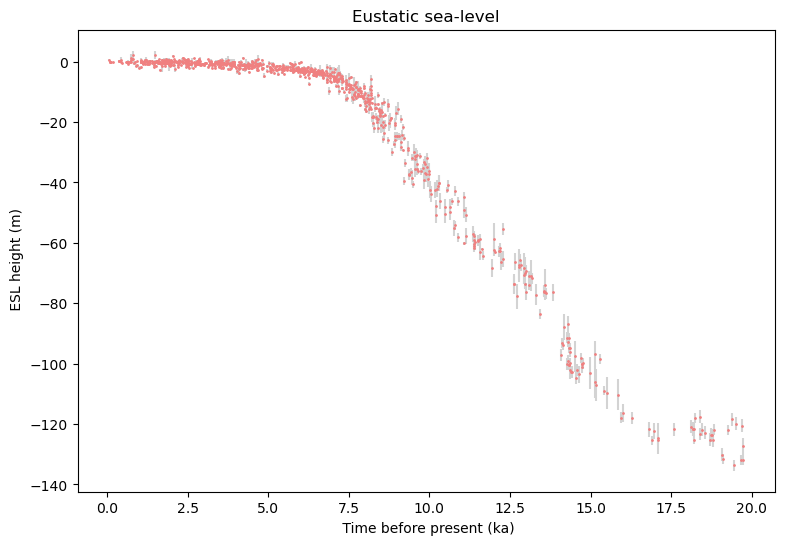

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

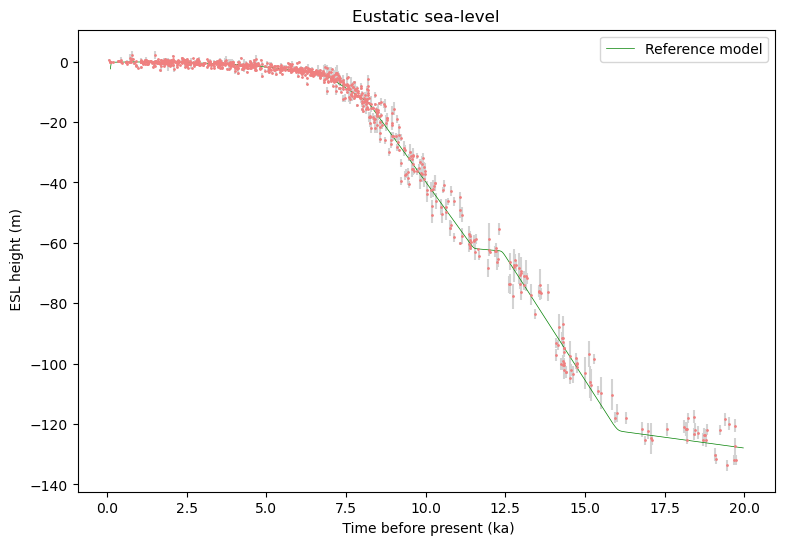

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'matrix solvers', 'sampling', 'optimization'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim",
        "cofi.border_collie_optimization"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee",
        "bayesbay",
        "neighpy"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

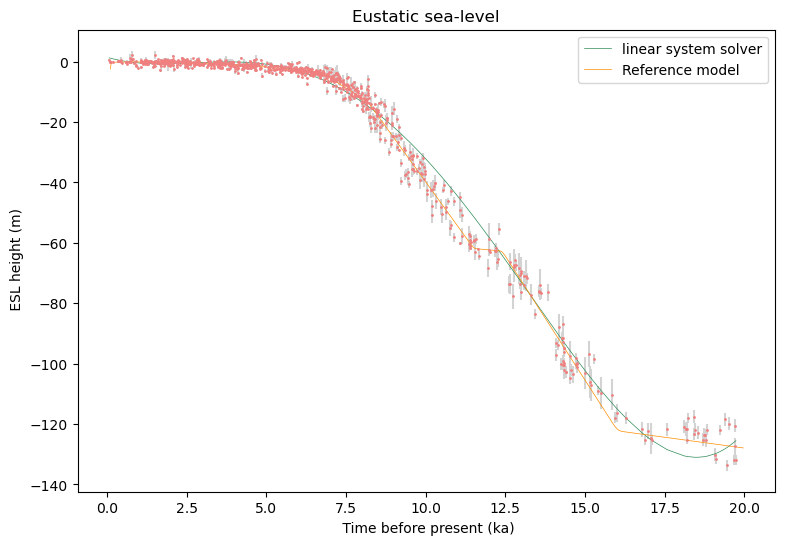

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]

Summary for inversion result
SUCCESS
----------------------------
fun: 310.0689929995379
nit: 560
nfev: 916
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[-0.81319113, -0.46081553,  0.61740809, -0.12663625,  0.00398136],
       [-0.81328903, -0.46081801,  0.61741429, -0.1266371 ,  0.0039814 ],
       [-0.81317886, -0.46081571,  0.61738786, -0.12663294,  0.00398125],
       [-0.81315239, -0.46081502,  0.61739705, -0.12663469,  0.0039813 ],
       [-0.81320724, -0.46081746,  0.61741117, -0.12663795,  0.00398147],
       [-0.81318091, -0.4608153 ,  0.61740441, -0.12663565,  0.00398136]]), array([310.068993  , 310.06899312, 310.0689937 , 310.06899379,
       310.06899388, 310.06899454]))
model: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]


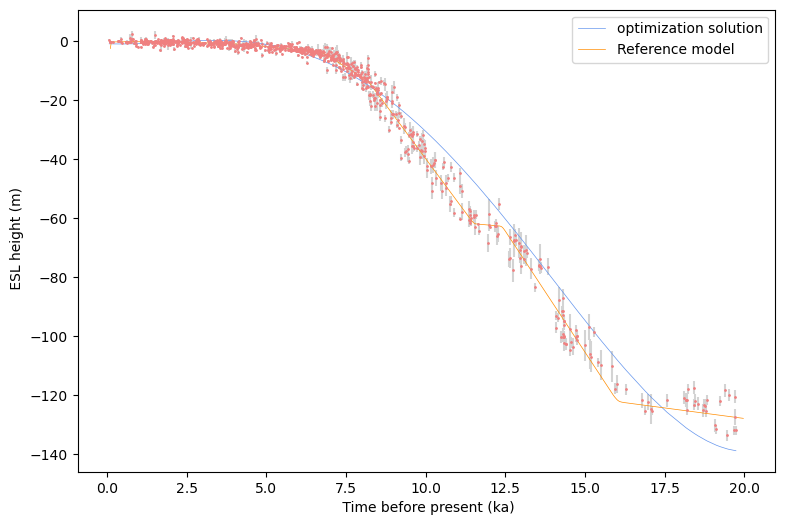

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


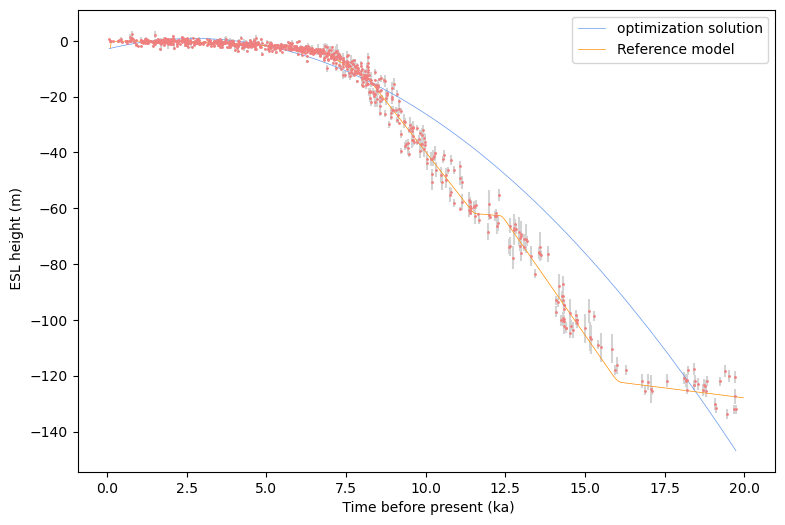

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                           | 0/10000 [00:00<?, ?it/s]

  0%|                                                                 | 14/10000 [00:00<01:12, 138.02it/s]

  0%|▏                                                                | 28/10000 [00:00<01:22, 120.34it/s]

  0%|▎                                                                | 41/10000 [00:00<01:25, 116.45it/s]

  1%|▎                                                                | 55/10000 [00:00<01:21, 122.36it/s]

  1%|▍                                                                | 69/10000 [00:00<01:17, 127.84it/s]

  1%|▌                                                                | 83/10000 [00:00<01:15, 131.62it/s]

  1%|▋                                                                | 97/10000 [00:00<01:14, 133.77it/s]

  1%|▋                                                               | 111/10000 [00:00<01:13, 135.31it/s]

  1%|▊                                                               | 125/10000 [00:00<01:12, 136.51it/s]

  1%|▉                                                               | 139/10000 [00:01<01:11, 137.46it/s]

  2%|▉                                                               | 153/10000 [00:01<01:11, 137.56it/s]

  2%|█                                                               | 167/10000 [00:01<01:11, 137.94it/s]

  2%|█▏                                                              | 181/10000 [00:01<01:10, 138.44it/s]

  2%|█▏                                                              | 195/10000 [00:01<01:10, 138.74it/s]

  2%|█▎                                                              | 209/10000 [00:01<01:10, 139.01it/s]

  2%|█▍                                                              | 223/10000 [00:01<01:10, 138.38it/s]

  2%|█▌                                                              | 237/10000 [00:01<01:10, 138.69it/s]

  3%|█▌                                                              | 251/10000 [00:01<01:10, 138.80it/s]

  3%|█▋                                                              | 265/10000 [00:01<01:10, 138.69it/s]

  3%|█▊                                                              | 279/10000 [00:02<01:09, 138.89it/s]

  3%|█▉                                                              | 293/10000 [00:02<01:11, 136.31it/s]

  3%|█▉                                                              | 307/10000 [00:02<01:10, 137.16it/s]

  3%|██                                                              | 321/10000 [00:02<01:10, 137.91it/s]

  3%|██▏                                                             | 335/10000 [00:02<01:09, 138.42it/s]

  3%|██▏                                                             | 349/10000 [00:02<01:09, 138.85it/s]

  4%|██▎                                                             | 363/10000 [00:02<01:09, 139.14it/s]

  4%|██▍                                                             | 377/10000 [00:02<01:09, 139.18it/s]

  4%|██▌                                                             | 391/10000 [00:02<01:08, 139.27it/s]

  4%|██▌                                                             | 405/10000 [00:02<01:08, 139.35it/s]

  4%|██▋                                                             | 419/10000 [00:03<01:08, 139.49it/s]

  4%|██▊                                                             | 433/10000 [00:03<01:08, 139.56it/s]

  4%|██▊                                                             | 447/10000 [00:03<01:08, 139.59it/s]

  5%|██▉                                                             | 461/10000 [00:03<01:18, 122.09it/s]

  5%|███                                                             | 475/10000 [00:03<01:15, 126.85it/s]

  5%|███▏                                                            | 489/10000 [00:03<01:12, 130.34it/s]

  5%|███▏                                                            | 503/10000 [00:03<01:11, 132.97it/s]

  5%|███▎                                                            | 517/10000 [00:03<01:12, 130.60it/s]

  5%|███▍                                                            | 531/10000 [00:03<01:11, 132.51it/s]

  5%|███▍                                                            | 545/10000 [00:04<01:10, 134.60it/s]

  6%|███▌                                                            | 559/10000 [00:04<01:09, 136.08it/s]

  6%|███▋                                                            | 573/10000 [00:04<01:08, 137.20it/s]

  6%|███▊                                                            | 587/10000 [00:04<01:08, 137.97it/s]

  6%|███▊                                                            | 601/10000 [00:04<01:08, 136.27it/s]

  6%|███▉                                                            | 615/10000 [00:04<01:08, 136.99it/s]

  6%|████                                                            | 629/10000 [00:04<01:08, 137.75it/s]

  6%|████                                                            | 643/10000 [00:04<01:07, 138.21it/s]

  7%|████▏                                                           | 657/10000 [00:04<01:07, 138.61it/s]

  7%|████▎                                                           | 671/10000 [00:04<01:07, 138.79it/s]

  7%|████▍                                                           | 685/10000 [00:05<01:07, 138.98it/s]

  7%|████▍                                                           | 699/10000 [00:05<01:06, 139.12it/s]

  7%|████▌                                                           | 713/10000 [00:05<01:06, 139.25it/s]

  7%|████▋                                                           | 727/10000 [00:05<01:06, 139.34it/s]

  7%|████▋                                                           | 741/10000 [00:05<01:06, 139.37it/s]

  8%|████▊                                                           | 755/10000 [00:05<01:06, 139.32it/s]

  8%|████▉                                                           | 769/10000 [00:05<01:06, 139.38it/s]

  8%|█████                                                           | 783/10000 [00:05<01:06, 139.46it/s]

  8%|█████                                                           | 797/10000 [00:05<01:06, 139.09it/s]

  8%|█████▏                                                          | 811/10000 [00:05<01:06, 139.15it/s]

  8%|█████▎                                                          | 825/10000 [00:06<01:05, 139.24it/s]

  8%|█████▎                                                          | 839/10000 [00:06<01:05, 139.30it/s]

  9%|█████▍                                                          | 853/10000 [00:06<01:05, 139.39it/s]

  9%|█████▌                                                          | 867/10000 [00:06<01:05, 139.44it/s]

  9%|█████▋                                                          | 881/10000 [00:06<01:05, 139.44it/s]

  9%|█████▋                                                          | 895/10000 [00:06<01:05, 139.18it/s]

  9%|█████▊                                                          | 909/10000 [00:06<01:05, 139.04it/s]

  9%|█████▉                                                          | 923/10000 [00:06<01:05, 139.09it/s]

  9%|█████▉                                                          | 937/10000 [00:06<01:05, 139.06it/s]

 10%|██████                                                          | 951/10000 [00:06<01:05, 139.12it/s]

 10%|██████▏                                                         | 965/10000 [00:07<01:04, 139.21it/s]

 10%|██████▎                                                         | 979/10000 [00:07<01:04, 139.35it/s]

 10%|██████▎                                                         | 993/10000 [00:07<01:04, 139.36it/s]

 10%|██████▎                                                        | 1007/10000 [00:07<01:04, 139.42it/s]

 10%|██████▍                                                        | 1021/10000 [00:07<01:04, 139.44it/s]

 10%|██████▌                                                        | 1035/10000 [00:07<01:04, 139.45it/s]

 10%|██████▌                                                        | 1049/10000 [00:07<01:04, 139.47it/s]

 11%|██████▋                                                        | 1063/10000 [00:07<01:04, 139.50it/s]

 11%|██████▊                                                        | 1077/10000 [00:07<01:04, 138.34it/s]

 11%|██████▊                                                        | 1091/10000 [00:07<01:04, 138.47it/s]

 11%|██████▉                                                        | 1105/10000 [00:08<01:04, 138.73it/s]

 11%|███████                                                        | 1119/10000 [00:08<01:03, 139.00it/s]

 11%|███████▏                                                       | 1133/10000 [00:08<01:03, 139.16it/s]

 11%|███████▏                                                       | 1147/10000 [00:08<01:03, 139.26it/s]

 12%|███████▎                                                       | 1161/10000 [00:08<01:03, 139.00it/s]

 12%|███████▍                                                       | 1175/10000 [00:08<01:03, 139.14it/s]

 12%|███████▍                                                       | 1189/10000 [00:08<01:03, 139.20it/s]

 12%|███████▌                                                       | 1203/10000 [00:08<01:03, 139.29it/s]

 12%|███████▋                                                       | 1217/10000 [00:08<01:03, 139.19it/s]

 12%|███████▊                                                       | 1231/10000 [00:08<01:02, 139.40it/s]

 12%|███████▊                                                       | 1245/10000 [00:09<01:02, 139.56it/s]

 13%|███████▉                                                       | 1259/10000 [00:09<01:03, 138.22it/s]

 13%|████████                                                       | 1273/10000 [00:09<01:02, 138.56it/s]

 13%|████████                                                       | 1287/10000 [00:09<01:02, 138.86it/s]

 13%|████████▏                                                      | 1301/10000 [00:09<01:02, 139.03it/s]

 13%|████████▎                                                      | 1315/10000 [00:09<01:02, 139.13it/s]

 13%|████████▎                                                      | 1329/10000 [00:09<01:02, 139.27it/s]

 13%|████████▍                                                      | 1343/10000 [00:09<01:02, 139.38it/s]

 14%|████████▌                                                      | 1357/10000 [00:09<01:02, 139.24it/s]

 14%|████████▋                                                      | 1371/10000 [00:09<01:01, 139.26it/s]

 14%|████████▋                                                      | 1385/10000 [00:10<01:01, 139.26it/s]

 14%|████████▊                                                      | 1399/10000 [00:10<01:01, 139.33it/s]

 14%|████████▉                                                      | 1413/10000 [00:10<01:01, 138.67it/s]

 14%|████████▉                                                      | 1427/10000 [00:10<01:01, 138.92it/s]

 14%|█████████                                                      | 1441/10000 [00:10<01:01, 139.00it/s]

 15%|█████████▏                                                     | 1455/10000 [00:10<01:01, 139.08it/s]

 15%|█████████▎                                                     | 1469/10000 [00:10<01:01, 139.23it/s]

 15%|█████████▎                                                     | 1483/10000 [00:10<01:01, 139.07it/s]

 15%|█████████▍                                                     | 1497/10000 [00:10<01:01, 139.08it/s]

 15%|█████████▌                                                     | 1511/10000 [00:10<01:01, 139.12it/s]

 15%|█████████▌                                                     | 1525/10000 [00:11<01:00, 139.24it/s]

 15%|█████████▋                                                     | 1539/10000 [00:11<01:00, 139.30it/s]

 16%|█████████▊                                                     | 1553/10000 [00:11<01:00, 139.35it/s]

 16%|█████████▊                                                     | 1567/10000 [00:11<01:00, 139.40it/s]

 16%|█████████▉                                                     | 1581/10000 [00:11<01:00, 139.38it/s]

 16%|██████████                                                     | 1595/10000 [00:11<01:00, 139.38it/s]

 16%|██████████▏                                                    | 1609/10000 [00:11<01:00, 138.61it/s]

 16%|██████████▏                                                    | 1623/10000 [00:11<01:00, 138.57it/s]

 16%|██████████▎                                                    | 1637/10000 [00:11<01:00, 138.74it/s]

 17%|██████████▍                                                    | 1651/10000 [00:11<01:01, 135.65it/s]

 17%|██████████▍                                                    | 1665/10000 [00:12<01:00, 136.66it/s]

 17%|██████████▌                                                    | 1679/10000 [00:12<01:00, 137.24it/s]

 17%|██████████▋                                                    | 1693/10000 [00:12<01:00, 137.38it/s]

 17%|██████████▊                                                    | 1707/10000 [00:12<01:00, 137.93it/s]

 17%|██████████▊                                                    | 1721/10000 [00:12<00:59, 138.39it/s]

 17%|██████████▉                                                    | 1735/10000 [00:12<00:59, 138.75it/s]

 17%|███████████                                                    | 1749/10000 [00:12<00:59, 139.01it/s]

 18%|███████████                                                    | 1763/10000 [00:12<00:59, 138.97it/s]

 18%|███████████▏                                                   | 1777/10000 [00:12<00:59, 139.06it/s]

 18%|███████████▎                                                   | 1791/10000 [00:13<00:58, 139.21it/s]

 18%|███████████▎                                                   | 1805/10000 [00:13<00:58, 139.23it/s]

 18%|███████████▍                                                   | 1819/10000 [00:13<00:58, 139.35it/s]

 18%|███████████▌                                                   | 1833/10000 [00:13<01:07, 120.42it/s]

 18%|███████████▋                                                   | 1847/10000 [00:13<01:05, 125.38it/s]

 19%|███████████▋                                                   | 1860/10000 [00:13<01:04, 126.18it/s]

 19%|███████████▊                                                   | 1874/10000 [00:13<01:02, 129.89it/s]

 19%|███████████▉                                                   | 1888/10000 [00:13<01:01, 132.59it/s]

 19%|███████████▉                                                   | 1902/10000 [00:13<01:04, 126.36it/s]

 19%|████████████                                                   | 1916/10000 [00:13<01:02, 129.94it/s]

 19%|████████████▏                                                  | 1930/10000 [00:14<01:01, 132.19it/s]

 19%|████████████▏                                                  | 1944/10000 [00:14<00:59, 134.33it/s]

 20%|████████████▎                                                  | 1958/10000 [00:14<00:59, 134.60it/s]

 20%|████████████▍                                                  | 1972/10000 [00:14<00:59, 133.81it/s]

 20%|████████████▌                                                  | 1986/10000 [00:14<00:59, 135.43it/s]

 20%|████████████▌                                                  | 2000/10000 [00:14<00:58, 136.59it/s]

 20%|████████████▋                                                  | 2014/10000 [00:14<00:58, 137.49it/s]

 20%|████████████▊                                                  | 2028/10000 [00:14<00:57, 137.76it/s]

 20%|████████████▊                                                  | 2042/10000 [00:14<00:57, 138.19it/s]

 21%|████████████▉                                                  | 2056/10000 [00:14<00:57, 138.49it/s]

 21%|█████████████                                                  | 2070/10000 [00:15<00:57, 138.31it/s]

 21%|█████████████▏                                                 | 2084/10000 [00:15<00:57, 138.69it/s]

 21%|█████████████▏                                                 | 2098/10000 [00:15<00:56, 138.95it/s]

 21%|█████████████▎                                                 | 2112/10000 [00:15<00:56, 139.04it/s]

 21%|█████████████▍                                                 | 2126/10000 [00:15<00:56, 139.15it/s]

 21%|█████████████▍                                                 | 2140/10000 [00:15<00:56, 139.24it/s]

 22%|█████████████▌                                                 | 2154/10000 [00:15<00:56, 139.04it/s]

 22%|█████████████▋                                                 | 2168/10000 [00:15<00:56, 139.07it/s]

 22%|█████████████▋                                                 | 2182/10000 [00:15<00:56, 139.03it/s]

 22%|█████████████▊                                                 | 2196/10000 [00:16<00:56, 139.16it/s]

 22%|█████████████▉                                                 | 2210/10000 [00:16<00:55, 139.34it/s]

 22%|██████████████                                                 | 2224/10000 [00:16<00:55, 139.43it/s]

 22%|██████████████                                                 | 2238/10000 [00:16<00:55, 138.97it/s]

 23%|██████████████▏                                                | 2252/10000 [00:16<00:55, 138.98it/s]

 23%|██████████████▎                                                | 2266/10000 [00:16<00:55, 139.18it/s]

 23%|██████████████▎                                                | 2280/10000 [00:16<00:55, 139.31it/s]

 23%|██████████████▍                                                | 2294/10000 [00:16<00:55, 139.38it/s]

 23%|██████████████▌                                                | 2308/10000 [00:16<00:55, 139.24it/s]

 23%|██████████████▋                                                | 2322/10000 [00:16<00:55, 139.25it/s]

 23%|██████████████▋                                                | 2336/10000 [00:17<00:55, 139.33it/s]

 24%|██████████████▊                                                | 2350/10000 [00:17<00:54, 139.33it/s]

 24%|██████████████▉                                                | 2364/10000 [00:17<00:56, 136.36it/s]

 24%|██████████████▉                                                | 2378/10000 [00:17<00:55, 136.13it/s]

 24%|███████████████                                                | 2392/10000 [00:17<00:55, 136.87it/s]

 24%|███████████████▏                                               | 2406/10000 [00:17<00:55, 137.59it/s]

 24%|███████████████▏                                               | 2420/10000 [00:17<00:54, 138.16it/s]

 24%|███████████████▎                                               | 2434/10000 [00:17<00:54, 138.55it/s]

 24%|███████████████▍                                               | 2448/10000 [00:17<00:54, 138.73it/s]

 25%|███████████████▌                                               | 2462/10000 [00:17<00:54, 138.90it/s]

 25%|███████████████▌                                               | 2476/10000 [00:18<00:57, 131.59it/s]

 25%|███████████████▋                                               | 2490/10000 [00:18<00:56, 133.81it/s]

 25%|███████████████▊                                               | 2504/10000 [00:18<00:55, 135.48it/s]

 25%|███████████████▊                                               | 2518/10000 [00:18<00:54, 136.66it/s]

 25%|███████████████▉                                               | 2532/10000 [00:18<00:54, 137.04it/s]

 25%|████████████████                                               | 2546/10000 [00:18<00:54, 137.31it/s]

 26%|████████████████▏                                              | 2560/10000 [00:18<00:53, 137.97it/s]

 26%|████████████████▏                                              | 2574/10000 [00:18<00:53, 138.40it/s]

 26%|████████████████▎                                              | 2588/10000 [00:18<00:53, 138.40it/s]

 26%|████████████████▍                                              | 2602/10000 [00:18<00:53, 138.61it/s]

 26%|████████████████▍                                              | 2616/10000 [00:19<00:53, 138.29it/s]

 26%|████████████████▌                                              | 2630/10000 [00:19<00:53, 138.66it/s]

 26%|████████████████▋                                              | 2644/10000 [00:19<00:52, 138.95it/s]

 27%|████████████████▋                                              | 2658/10000 [00:19<00:52, 139.11it/s]

 27%|████████████████▊                                              | 2672/10000 [00:19<00:52, 139.12it/s]

 27%|████████████████▉                                              | 2686/10000 [00:19<00:52, 139.20it/s]

 27%|█████████████████                                              | 2700/10000 [00:19<00:52, 139.30it/s]

 27%|█████████████████                                              | 2714/10000 [00:19<00:52, 139.34it/s]

 27%|█████████████████▏                                             | 2728/10000 [00:19<00:52, 139.29it/s]

 27%|█████████████████▎                                             | 2742/10000 [00:19<00:52, 139.24it/s]

 28%|█████████████████▎                                             | 2756/10000 [00:20<00:52, 139.22it/s]

 28%|█████████████████▍                                             | 2770/10000 [00:20<00:51, 139.29it/s]

 28%|█████████████████▌                                             | 2784/10000 [00:20<00:52, 138.76it/s]

 28%|█████████████████▋                                             | 2798/10000 [00:20<00:51, 138.99it/s]

 28%|█████████████████▋                                             | 2812/10000 [00:20<00:51, 139.09it/s]

 28%|█████████████████▊                                             | 2826/10000 [00:20<00:51, 138.50it/s]

 28%|█████████████████▉                                             | 2840/10000 [00:20<00:51, 138.53it/s]

 29%|█████████████████▉                                             | 2854/10000 [00:20<00:51, 138.75it/s]

 29%|██████████████████                                             | 2868/10000 [00:20<00:51, 138.81it/s]

 29%|██████████████████▏                                            | 2882/10000 [00:20<00:51, 138.78it/s]

 29%|██████████████████▏                                            | 2896/10000 [00:21<00:51, 138.98it/s]

 29%|██████████████████▎                                            | 2910/10000 [00:21<00:51, 138.57it/s]

 29%|██████████████████▍                                            | 2924/10000 [00:21<00:51, 138.08it/s]

 29%|██████████████████▌                                            | 2938/10000 [00:21<00:50, 138.50it/s]

 30%|██████████████████▌                                            | 2952/10000 [00:21<00:50, 138.79it/s]

 30%|██████████████████▋                                            | 2966/10000 [00:21<00:50, 138.99it/s]

 30%|██████████████████▊                                            | 2980/10000 [00:21<00:50, 138.37it/s]

 30%|██████████████████▊                                            | 2994/10000 [00:21<00:50, 138.65it/s]

 30%|██████████████████▉                                            | 3008/10000 [00:21<00:50, 138.80it/s]

 30%|███████████████████                                            | 3022/10000 [00:21<00:50, 138.92it/s]

 30%|███████████████████▏                                           | 3036/10000 [00:22<00:50, 139.06it/s]

 30%|███████████████████▏                                           | 3050/10000 [00:22<00:49, 139.16it/s]

 31%|███████████████████▎                                           | 3064/10000 [00:22<00:49, 139.21it/s]

 31%|███████████████████▍                                           | 3078/10000 [00:22<00:49, 139.21it/s]

 31%|███████████████████▍                                           | 3092/10000 [00:22<00:49, 139.18it/s]

 31%|███████████████████▌                                           | 3106/10000 [00:22<00:49, 139.29it/s]

 31%|███████████████████▋                                           | 3120/10000 [00:22<00:49, 139.41it/s]

 31%|███████████████████▋                                           | 3134/10000 [00:22<00:49, 139.43it/s]

 31%|███████████████████▊                                           | 3148/10000 [00:22<00:49, 139.24it/s]

 32%|███████████████████▉                                           | 3162/10000 [00:22<00:49, 138.55it/s]

 32%|████████████████████                                           | 3176/10000 [00:23<00:49, 138.71it/s]

 32%|████████████████████                                           | 3190/10000 [00:23<00:49, 138.96it/s]

 32%|████████████████████▏                                          | 3204/10000 [00:23<00:48, 139.12it/s]

 32%|████████████████████▎                                          | 3218/10000 [00:23<00:48, 139.22it/s]

 32%|████████████████████▎                                          | 3232/10000 [00:23<00:48, 139.29it/s]

 32%|████████████████████▍                                          | 3246/10000 [00:23<00:48, 139.28it/s]

 33%|████████████████████▌                                          | 3260/10000 [00:23<00:48, 139.37it/s]

 33%|████████████████████▋                                          | 3274/10000 [00:23<00:48, 139.40it/s]

 33%|████████████████████▋                                          | 3288/10000 [00:23<00:48, 138.12it/s]

 33%|████████████████████▊                                          | 3302/10000 [00:23<00:48, 138.40it/s]

 33%|████████████████████▉                                          | 3316/10000 [00:24<00:48, 138.72it/s]

 33%|████████████████████▉                                          | 3330/10000 [00:24<00:48, 138.95it/s]

 33%|█████████████████████                                          | 3344/10000 [00:24<00:47, 139.11it/s]

 34%|█████████████████████▏                                         | 3358/10000 [00:24<00:47, 139.22it/s]

 34%|█████████████████████▏                                         | 3372/10000 [00:24<00:47, 139.24it/s]

 34%|█████████████████████▎                                         | 3386/10000 [00:24<00:47, 139.30it/s]

 34%|█████████████████████▍                                         | 3400/10000 [00:24<00:47, 139.36it/s]

 34%|█████████████████████▌                                         | 3414/10000 [00:24<00:47, 139.15it/s]

 34%|█████████████████████▌                                         | 3428/10000 [00:24<00:47, 139.13it/s]

 34%|█████████████████████▋                                         | 3442/10000 [00:24<00:47, 139.21it/s]

 35%|█████████████████████▊                                         | 3456/10000 [00:25<00:47, 139.06it/s]

 35%|█████████████████████▊                                         | 3470/10000 [00:25<00:46, 139.18it/s]

 35%|█████████████████████▉                                         | 3484/10000 [00:25<00:46, 139.29it/s]

 35%|██████████████████████                                         | 3498/10000 [00:25<00:46, 139.09it/s]

 35%|██████████████████████▏                                        | 3512/10000 [00:25<00:46, 139.18it/s]

 35%|██████████████████████▏                                        | 3526/10000 [00:25<00:46, 139.27it/s]

 35%|██████████████████████▎                                        | 3540/10000 [00:25<00:46, 139.37it/s]

 36%|██████████████████████▍                                        | 3554/10000 [00:25<00:46, 139.25it/s]

 36%|██████████████████████▍                                        | 3568/10000 [00:25<00:46, 139.27it/s]

 36%|██████████████████████▌                                        | 3582/10000 [00:25<00:46, 139.36it/s]

 36%|██████████████████████▋                                        | 3596/10000 [00:26<00:45, 139.41it/s]

 36%|██████████████████████▋                                        | 3610/10000 [00:26<00:45, 139.46it/s]

 36%|██████████████████████▊                                        | 3624/10000 [00:26<00:45, 139.48it/s]

 36%|██████████████████████▉                                        | 3638/10000 [00:26<00:46, 138.13it/s]

 37%|███████████████████████                                        | 3652/10000 [00:26<00:45, 138.54it/s]

 37%|███████████████████████                                        | 3666/10000 [00:26<00:45, 138.87it/s]

 37%|███████████████████████▏                                       | 3680/10000 [00:26<00:45, 139.07it/s]

 37%|███████████████████████▎                                       | 3694/10000 [00:26<00:45, 139.09it/s]

 37%|███████████████████████▎                                       | 3708/10000 [00:26<00:45, 138.99it/s]

 37%|███████████████████████▍                                       | 3722/10000 [00:27<00:45, 139.19it/s]

 37%|███████████████████████▌                                       | 3736/10000 [00:27<00:44, 139.29it/s]

 38%|███████████████████████▋                                       | 3750/10000 [00:27<00:46, 135.23it/s]

 38%|███████████████████████▋                                       | 3764/10000 [00:27<00:45, 136.44it/s]

 38%|███████████████████████▊                                       | 3778/10000 [00:27<00:45, 137.31it/s]

 38%|███████████████████████▉                                       | 3792/10000 [00:27<00:44, 137.99it/s]

 38%|███████████████████████▉                                       | 3806/10000 [00:27<00:44, 138.44it/s]

 38%|████████████████████████                                       | 3820/10000 [00:27<00:44, 138.78it/s]

 38%|████████████████████████▏                                      | 3834/10000 [00:27<00:44, 138.61it/s]

 38%|████████████████████████▏                                      | 3848/10000 [00:27<00:44, 138.83it/s]

 39%|████████████████████████▎                                      | 3862/10000 [00:28<00:44, 138.81it/s]

 39%|████████████████████████▍                                      | 3876/10000 [00:28<00:45, 135.10it/s]

 39%|████████████████████████▌                                      | 3890/10000 [00:28<00:44, 136.40it/s]

 39%|████████████████████████▌                                      | 3904/10000 [00:28<00:44, 137.29it/s]

 39%|████████████████████████▋                                      | 3918/10000 [00:28<00:44, 137.91it/s]

 39%|████████████████████████▊                                      | 3932/10000 [00:28<00:43, 138.10it/s]

 39%|████████████████████████▊                                      | 3946/10000 [00:28<00:43, 138.54it/s]

 40%|████████████████████████▉                                      | 3960/10000 [00:28<00:43, 138.83it/s]

 40%|█████████████████████████                                      | 3974/10000 [00:28<00:43, 138.89it/s]

 40%|█████████████████████████                                      | 3988/10000 [00:28<00:43, 139.03it/s]

 40%|█████████████████████████▏                                     | 4002/10000 [00:29<00:43, 139.16it/s]

 40%|█████████████████████████▎                                     | 4016/10000 [00:29<00:43, 139.12it/s]

 40%|█████████████████████████▍                                     | 4030/10000 [00:29<00:42, 139.19it/s]

 40%|█████████████████████████▍                                     | 4044/10000 [00:29<00:42, 139.31it/s]

 41%|█████████████████████████▌                                     | 4058/10000 [00:29<00:42, 139.32it/s]

 41%|█████████████████████████▋                                     | 4072/10000 [00:29<00:42, 139.39it/s]

 41%|█████████████████████████▋                                     | 4086/10000 [00:29<00:42, 139.42it/s]

 41%|█████████████████████████▊                                     | 4100/10000 [00:29<00:42, 139.42it/s]

 41%|█████████████████████████▉                                     | 4114/10000 [00:29<00:42, 139.35it/s]

 41%|██████████████████████████                                     | 4128/10000 [00:29<00:42, 139.34it/s]

 41%|██████████████████████████                                     | 4142/10000 [00:30<00:47, 122.80it/s]

 42%|██████████████████████████▏                                    | 4156/10000 [00:30<00:45, 127.39it/s]

 42%|██████████████████████████▎                                    | 4170/10000 [00:30<00:44, 130.32it/s]

 42%|██████████████████████████▎                                    | 4184/10000 [00:30<00:43, 132.87it/s]

 42%|██████████████████████████▍                                    | 4198/10000 [00:30<00:43, 134.78it/s]

 42%|██████████████████████████▌                                    | 4212/10000 [00:30<00:42, 136.17it/s]

 42%|██████████████████████████▌                                    | 4226/10000 [00:30<00:42, 137.19it/s]

 42%|██████████████████████████▋                                    | 4240/10000 [00:30<00:41, 137.89it/s]

 43%|██████████████████████████▊                                    | 4254/10000 [00:30<00:41, 137.60it/s]

 43%|██████████████████████████▉                                    | 4268/10000 [00:30<00:41, 138.01it/s]

 43%|██████████████████████████▉                                    | 4282/10000 [00:31<00:41, 138.43it/s]

 43%|███████████████████████████                                    | 4296/10000 [00:31<00:41, 138.71it/s]

 43%|███████████████████████████▏                                   | 4310/10000 [00:31<00:40, 139.00it/s]

 43%|███████████████████████████▏                                   | 4324/10000 [00:31<00:40, 139.19it/s]

 43%|███████████████████████████▎                                   | 4338/10000 [00:31<00:40, 139.30it/s]

 44%|███████████████████████████▍                                   | 4352/10000 [00:31<00:40, 139.38it/s]

 44%|███████████████████████████▌                                   | 4366/10000 [00:31<00:40, 138.60it/s]

 44%|███████████████████████████▌                                   | 4380/10000 [00:31<00:40, 138.74it/s]

 44%|███████████████████████████▋                                   | 4394/10000 [00:31<00:40, 138.85it/s]

 44%|███████████████████████████▊                                   | 4408/10000 [00:31<00:40, 139.06it/s]

 44%|███████████████████████████▊                                   | 4422/10000 [00:32<00:40, 139.20it/s]

 44%|███████████████████████████▉                                   | 4436/10000 [00:32<00:39, 139.31it/s]

 44%|████████████████████████████                                   | 4450/10000 [00:32<00:39, 139.37it/s]

 45%|████████████████████████████                                   | 4464/10000 [00:32<00:39, 139.47it/s]

 45%|████████████████████████████▏                                  | 4478/10000 [00:32<00:39, 139.52it/s]

 45%|████████████████████████████▎                                  | 4492/10000 [00:32<00:39, 139.58it/s]

 45%|████████████████████████████▍                                  | 4506/10000 [00:32<00:39, 139.58it/s]

 45%|████████████████████████████▍                                  | 4520/10000 [00:32<00:39, 139.45it/s]

 45%|████████████████████████████▌                                  | 4534/10000 [00:32<00:39, 139.40it/s]

 45%|████████████████████████████▋                                  | 4548/10000 [00:33<00:39, 139.42it/s]

 46%|████████████████████████████▋                                  | 4562/10000 [00:33<00:40, 133.77it/s]

 46%|████████████████████████████▊                                  | 4576/10000 [00:33<00:41, 132.03it/s]

 46%|████████████████████████████▉                                  | 4590/10000 [00:33<00:40, 134.18it/s]

 46%|█████████████████████████████                                  | 4604/10000 [00:33<00:39, 135.70it/s]

 46%|█████████████████████████████                                  | 4618/10000 [00:33<00:39, 136.89it/s]

 46%|█████████████████████████████▏                                 | 4632/10000 [00:33<00:39, 137.61it/s]

 46%|█████████████████████████████▎                                 | 4646/10000 [00:33<00:38, 138.22it/s]

 47%|█████████████████████████████▎                                 | 4660/10000 [00:33<00:38, 137.39it/s]

 47%|█████████████████████████████▍                                 | 4674/10000 [00:33<00:38, 137.32it/s]

 47%|█████████████████████████████▌                                 | 4688/10000 [00:34<00:38, 138.00it/s]

 47%|█████████████████████████████▌                                 | 4702/10000 [00:34<00:38, 138.55it/s]

 47%|█████████████████████████████▋                                 | 4716/10000 [00:34<00:38, 138.81it/s]

 47%|█████████████████████████████▊                                 | 4730/10000 [00:34<00:37, 139.05it/s]

 47%|█████████████████████████████▉                                 | 4744/10000 [00:34<00:37, 139.20it/s]

 48%|█████████████████████████████▉                                 | 4758/10000 [00:34<00:37, 139.35it/s]

 48%|██████████████████████████████                                 | 4772/10000 [00:34<00:37, 139.45it/s]

 48%|██████████████████████████████▏                                | 4786/10000 [00:34<00:37, 139.51it/s]

 48%|██████████████████████████████▏                                | 4800/10000 [00:34<00:37, 139.48it/s]

 48%|██████████████████████████████▎                                | 4814/10000 [00:34<00:37, 139.40it/s]

 48%|██████████████████████████████▍                                | 4828/10000 [00:35<00:37, 139.47it/s]

 48%|██████████████████████████████▌                                | 4842/10000 [00:35<00:36, 139.51it/s]

 49%|██████████████████████████████▌                                | 4856/10000 [00:35<00:36, 139.55it/s]

 49%|██████████████████████████████▋                                | 4870/10000 [00:35<00:36, 139.60it/s]

 49%|██████████████████████████████▊                                | 4884/10000 [00:35<00:36, 139.62it/s]

 49%|██████████████████████████████▊                                | 4898/10000 [00:35<00:36, 139.62it/s]

 49%|██████████████████████████████▉                                | 4912/10000 [00:35<00:36, 139.55it/s]

 49%|███████████████████████████████                                | 4926/10000 [00:35<00:36, 139.57it/s]

 49%|███████████████████████████████                                | 4940/10000 [00:35<00:36, 139.29it/s]

 50%|███████████████████████████████▏                               | 4954/10000 [00:35<00:36, 139.31it/s]

 50%|███████████████████████████████▎                               | 4968/10000 [00:36<00:36, 139.39it/s]

 50%|███████████████████████████████▍                               | 4982/10000 [00:36<00:35, 139.47it/s]

 50%|███████████████████████████████▍                               | 4996/10000 [00:36<00:35, 139.09it/s]

 50%|███████████████████████████████▌                               | 5010/10000 [00:36<00:35, 138.81it/s]

 50%|███████████████████████████████▋                               | 5024/10000 [00:36<00:35, 139.04it/s]

 50%|███████████████████████████████▋                               | 5038/10000 [00:36<00:35, 139.23it/s]

 51%|███████████████████████████████▊                               | 5052/10000 [00:36<00:35, 139.35it/s]

 51%|███████████████████████████████▉                               | 5066/10000 [00:36<00:35, 139.14it/s]

 51%|████████████████████████████████                               | 5080/10000 [00:36<00:35, 138.90it/s]

 51%|████████████████████████████████                               | 5094/10000 [00:36<00:35, 138.97it/s]

 51%|████████████████████████████████▏                              | 5108/10000 [00:37<00:35, 139.16it/s]

 51%|████████████████████████████████▎                              | 5122/10000 [00:37<00:35, 139.33it/s]

 51%|████████████████████████████████▎                              | 5136/10000 [00:37<00:34, 139.41it/s]

 52%|████████████████████████████████▍                              | 5150/10000 [00:37<00:34, 139.45it/s]

 52%|████████████████████████████████▌                              | 5164/10000 [00:37<00:34, 139.49it/s]

 52%|████████████████████████████████▌                              | 5178/10000 [00:37<00:34, 139.53it/s]

 52%|████████████████████████████████▋                              | 5192/10000 [00:37<00:34, 139.37it/s]

 52%|████████████████████████████████▊                              | 5206/10000 [00:37<00:34, 139.39it/s]

 52%|████████████████████████████████▉                              | 5220/10000 [00:37<00:34, 139.33it/s]

 52%|████████████████████████████████▉                              | 5234/10000 [00:37<00:34, 139.30it/s]

 52%|█████████████████████████████████                              | 5248/10000 [00:38<00:34, 139.40it/s]

 53%|█████████████████████████████████▏                             | 5262/10000 [00:38<00:34, 135.68it/s]

 53%|█████████████████████████████████▏                             | 5276/10000 [00:38<00:34, 136.82it/s]

 53%|█████████████████████████████████▎                             | 5290/10000 [00:38<00:34, 137.63it/s]

 53%|█████████████████████████████████▍                             | 5304/10000 [00:38<00:33, 138.23it/s]

 53%|█████████████████████████████████▌                             | 5318/10000 [00:38<00:33, 138.51it/s]

 53%|█████████████████████████████████▌                             | 5332/10000 [00:38<00:33, 138.13it/s]

 53%|█████████████████████████████████▋                             | 5346/10000 [00:38<00:33, 138.56it/s]

 54%|█████████████████████████████████▊                             | 5360/10000 [00:38<00:33, 138.11it/s]

 54%|█████████████████████████████████▊                             | 5374/10000 [00:38<00:33, 138.49it/s]

 54%|█████████████████████████████████▉                             | 5388/10000 [00:39<00:33, 138.83it/s]

 54%|██████████████████████████████████                             | 5402/10000 [00:39<00:33, 138.65it/s]

 54%|██████████████████████████████████                             | 5416/10000 [00:39<00:33, 138.73it/s]

 54%|██████████████████████████████████▏                            | 5430/10000 [00:39<00:32, 138.93it/s]

 54%|██████████████████████████████████▎                            | 5444/10000 [00:39<00:32, 138.99it/s]

 55%|██████████████████████████████████▍                            | 5458/10000 [00:39<00:32, 139.09it/s]

 55%|██████████████████████████████████▍                            | 5472/10000 [00:39<00:32, 139.24it/s]

 55%|██████████████████████████████████▌                            | 5486/10000 [00:39<00:32, 139.30it/s]

 55%|██████████████████████████████████▋                            | 5500/10000 [00:39<00:32, 138.25it/s]

 55%|██████████████████████████████████▋                            | 5514/10000 [00:39<00:32, 137.81it/s]

 55%|██████████████████████████████████▊                            | 5528/10000 [00:40<00:32, 138.22it/s]

 55%|██████████████████████████████████▉                            | 5542/10000 [00:40<00:32, 138.53it/s]

 56%|███████████████████████████████████                            | 5556/10000 [00:40<00:32, 137.82it/s]

 56%|███████████████████████████████████                            | 5570/10000 [00:40<00:32, 138.20it/s]

 56%|███████████████████████████████████▏                           | 5584/10000 [00:40<00:31, 138.14it/s]

 56%|███████████████████████████████████▎                           | 5598/10000 [00:40<00:31, 138.15it/s]

 56%|███████████████████████████████████▎                           | 5612/10000 [00:40<00:31, 138.49it/s]

 56%|███████████████████████████████████▍                           | 5626/10000 [00:40<00:31, 138.90it/s]

 56%|███████████████████████████████████▌                           | 5640/10000 [00:40<00:31, 138.92it/s]

 57%|███████████████████████████████████▌                           | 5654/10000 [00:40<00:31, 138.90it/s]

 57%|███████████████████████████████████▋                           | 5668/10000 [00:41<00:42, 101.30it/s]

 57%|███████████████████████████████████▊                           | 5682/10000 [00:41<00:39, 110.29it/s]

 57%|███████████████████████████████████▉                           | 5696/10000 [00:41<00:36, 117.54it/s]

 57%|███████████████████████████████████▉                           | 5710/10000 [00:41<00:34, 123.30it/s]

 57%|████████████████████████████████████                           | 5724/10000 [00:41<00:34, 125.42it/s]

 57%|████████████████████████████████████▏                          | 5738/10000 [00:41<00:33, 128.52it/s]

 58%|████████████████████████████████████▏                          | 5752/10000 [00:41<00:32, 131.51it/s]

 58%|████████████████████████████████████▎                          | 5766/10000 [00:41<00:31, 133.54it/s]

 58%|████████████████████████████████████▍                          | 5780/10000 [00:42<00:31, 133.17it/s]

 58%|████████████████████████████████████▌                          | 5794/10000 [00:42<00:31, 134.95it/s]

 58%|████████████████████████████████████▌                          | 5808/10000 [00:42<00:31, 134.71it/s]

 58%|████████████████████████████████████▋                          | 5822/10000 [00:42<00:30, 135.90it/s]

 58%|████████████████████████████████████▊                          | 5836/10000 [00:42<00:30, 136.88it/s]

 58%|████████████████████████████████████▊                          | 5850/10000 [00:42<00:30, 136.34it/s]

 59%|████████████████████████████████████▉                          | 5864/10000 [00:42<00:30, 135.06it/s]

 59%|█████████████████████████████████████                          | 5878/10000 [00:42<00:30, 136.23it/s]

 59%|█████████████████████████████████████                          | 5892/10000 [00:42<00:30, 136.85it/s]

 59%|█████████████████████████████████████▏                         | 5906/10000 [00:42<00:29, 137.43it/s]

 59%|█████████████████████████████████████▎                         | 5920/10000 [00:43<00:29, 137.95it/s]

 59%|█████████████████████████████████████▍                         | 5934/10000 [00:43<00:29, 138.37it/s]

 59%|█████████████████████████████████████▍                         | 5948/10000 [00:43<00:29, 138.69it/s]

 60%|█████████████████████████████████████▌                         | 5962/10000 [00:43<00:29, 138.81it/s]

 60%|█████████████████████████████████████▋                         | 5976/10000 [00:43<00:28, 138.90it/s]

 60%|█████████████████████████████████████▋                         | 5990/10000 [00:43<00:28, 139.05it/s]

 60%|█████████████████████████████████████▊                         | 6004/10000 [00:43<00:28, 138.00it/s]

 60%|█████████████████████████████████████▉                         | 6018/10000 [00:43<00:28, 138.36it/s]

 60%|██████████████████████████████████████                         | 6032/10000 [00:43<00:28, 137.25it/s]

 60%|██████████████████████████████████████                         | 6046/10000 [00:43<00:28, 137.77it/s]

 61%|██████████████████████████████████████▏                        | 6060/10000 [00:44<00:28, 138.20it/s]

 61%|██████████████████████████████████████▎                        | 6074/10000 [00:44<00:28, 138.44it/s]

 61%|██████████████████████████████████████▎                        | 6088/10000 [00:44<00:28, 138.43it/s]

 61%|██████████████████████████████████████▍                        | 6102/10000 [00:44<00:28, 138.73it/s]

 61%|██████████████████████████████████████▌                        | 6116/10000 [00:44<00:27, 138.96it/s]

 61%|██████████████████████████████████████▌                        | 6130/10000 [00:44<00:27, 139.20it/s]

 61%|██████████████████████████████████████▋                        | 6144/10000 [00:44<00:27, 139.20it/s]

 62%|██████████████████████████████████████▊                        | 6158/10000 [00:44<00:27, 139.17it/s]

 62%|██████████████████████████████████████▉                        | 6172/10000 [00:44<00:27, 138.99it/s]

 62%|██████████████████████████████████████▉                        | 6186/10000 [00:44<00:27, 138.95it/s]

 62%|███████████████████████████████████████                        | 6200/10000 [00:45<00:27, 139.05it/s]

 62%|███████████████████████████████████████▏                       | 6214/10000 [00:45<00:27, 139.15it/s]

 62%|███████████████████████████████████████▏                       | 6228/10000 [00:45<00:27, 139.21it/s]

 62%|███████████████████████████████████████▎                       | 6242/10000 [00:45<00:27, 139.01it/s]

 63%|███████████████████████████████████████▍                       | 6256/10000 [00:45<00:26, 139.05it/s]

 63%|███████████████████████████████████████▌                       | 6270/10000 [00:45<00:26, 139.23it/s]

 63%|███████████████████████████████████████▌                       | 6284/10000 [00:45<00:26, 137.86it/s]

 63%|███████████████████████████████████████▋                       | 6298/10000 [00:45<00:26, 138.35it/s]

 63%|███████████████████████████████████████▊                       | 6312/10000 [00:45<00:26, 138.56it/s]

 63%|███████████████████████████████████████▊                       | 6326/10000 [00:45<00:26, 138.76it/s]

 63%|███████████████████████████████████████▉                       | 6340/10000 [00:46<00:26, 139.04it/s]

 64%|████████████████████████████████████████                       | 6354/10000 [00:46<00:26, 139.22it/s]

 64%|████████████████████████████████████████                       | 6368/10000 [00:46<00:26, 139.33it/s]

 64%|████████████████████████████████████████▏                      | 6382/10000 [00:46<00:25, 139.46it/s]

 64%|████████████████████████████████████████▎                      | 6396/10000 [00:46<00:25, 139.50it/s]

 64%|████████████████████████████████████████▍                      | 6410/10000 [00:46<00:25, 139.51it/s]

 64%|████████████████████████████████████████▍                      | 6424/10000 [00:46<00:25, 139.58it/s]

 64%|████████████████████████████████████████▌                      | 6438/10000 [00:46<00:25, 139.56it/s]

 65%|████████████████████████████████████████▋                      | 6452/10000 [00:46<00:25, 139.45it/s]

 65%|████████████████████████████████████████▋                      | 6466/10000 [00:46<00:25, 139.38it/s]

 65%|████████████████████████████████████████▊                      | 6480/10000 [00:47<00:25, 139.42it/s]

 65%|████████████████████████████████████████▉                      | 6494/10000 [00:47<00:25, 139.36it/s]

 65%|█████████████████████████████████████████                      | 6508/10000 [00:47<00:25, 139.41it/s]

 65%|█████████████████████████████████████████                      | 6522/10000 [00:47<00:24, 139.50it/s]

 65%|█████████████████████████████████████████▏                     | 6536/10000 [00:47<00:24, 139.53it/s]

 66%|█████████████████████████████████████████▎                     | 6550/10000 [00:47<00:24, 139.55it/s]

 66%|█████████████████████████████████████████▎                     | 6564/10000 [00:47<00:24, 139.50it/s]

 66%|█████████████████████████████████████████▍                     | 6578/10000 [00:47<00:24, 139.51it/s]

 66%|█████████████████████████████████████████▌                     | 6592/10000 [00:47<00:24, 139.34it/s]

 66%|█████████████████████████████████████████▌                     | 6606/10000 [00:47<00:24, 139.09it/s]

 66%|█████████████████████████████████████████▋                     | 6620/10000 [00:48<00:24, 139.07it/s]

 66%|█████████████████████████████████████████▊                     | 6634/10000 [00:48<00:24, 139.22it/s]

 66%|█████████████████████████████████████████▉                     | 6648/10000 [00:48<00:24, 139.35it/s]

 67%|█████████████████████████████████████████▉                     | 6662/10000 [00:48<00:23, 139.43it/s]

 67%|██████████████████████████████████████████                     | 6676/10000 [00:48<00:23, 139.45it/s]

 67%|██████████████████████████████████████████▏                    | 6690/10000 [00:48<00:23, 139.16it/s]

 67%|██████████████████████████████████████████▏                    | 6704/10000 [00:48<00:23, 139.30it/s]

 67%|██████████████████████████████████████████▎                    | 6718/10000 [00:48<00:23, 139.13it/s]

 67%|██████████████████████████████████████████▍                    | 6732/10000 [00:48<00:23, 139.07it/s]

 67%|██████████████████████████████████████████▍                    | 6746/10000 [00:48<00:23, 139.20it/s]

 68%|██████████████████████████████████████████▌                    | 6760/10000 [00:49<00:23, 139.34it/s]

 68%|██████████████████████████████████████████▋                    | 6774/10000 [00:49<00:23, 139.39it/s]

 68%|██████████████████████████████████████████▊                    | 6788/10000 [00:49<00:23, 139.47it/s]

 68%|██████████████████████████████████████████▊                    | 6802/10000 [00:49<00:22, 139.53it/s]

 68%|██████████████████████████████████████████▉                    | 6816/10000 [00:49<00:22, 139.52it/s]

 68%|███████████████████████████████████████████                    | 6830/10000 [00:49<00:22, 139.40it/s]

 68%|███████████████████████████████████████████                    | 6844/10000 [00:49<00:22, 139.49it/s]

 69%|███████████████████████████████████████████▏                   | 6858/10000 [00:49<00:22, 139.48it/s]

 69%|███████████████████████████████████████████▎                   | 6872/10000 [00:49<00:22, 138.87it/s]

 69%|███████████████████████████████████████████▍                   | 6886/10000 [00:49<00:22, 139.00it/s]

 69%|███████████████████████████████████████████▍                   | 6900/10000 [00:50<00:22, 139.13it/s]

 69%|███████████████████████████████████████████▌                   | 6914/10000 [00:50<00:22, 139.20it/s]

 69%|███████████████████████████████████████████▋                   | 6928/10000 [00:50<00:22, 139.35it/s]

 69%|███████████████████████████████████████████▋                   | 6942/10000 [00:50<00:21, 139.39it/s]

 70%|███████████████████████████████████████████▊                   | 6956/10000 [00:50<00:21, 139.37it/s]

 70%|███████████████████████████████████████████▉                   | 6970/10000 [00:50<00:21, 139.43it/s]

 70%|███████████████████████████████████████████▉                   | 6984/10000 [00:50<00:21, 139.48it/s]

 70%|████████████████████████████████████████████                   | 6998/10000 [00:50<00:21, 139.49it/s]

 70%|████████████████████████████████████████████▏                  | 7012/10000 [00:50<00:21, 139.43it/s]

 70%|████████████████████████████████████████████▎                  | 7026/10000 [00:50<00:21, 139.49it/s]

 70%|████████████████████████████████████████████▎                  | 7040/10000 [00:51<00:21, 139.55it/s]

 71%|████████████████████████████████████████████▍                  | 7054/10000 [00:51<00:21, 139.57it/s]

 71%|████████████████████████████████████████████▌                  | 7068/10000 [00:51<00:21, 139.59it/s]

 71%|████████████████████████████████████████████▌                  | 7082/10000 [00:51<00:20, 139.61it/s]

 71%|████████████████████████████████████████████▋                  | 7096/10000 [00:51<00:20, 139.55it/s]

 71%|████████████████████████████████████████████▊                  | 7110/10000 [00:51<00:20, 139.58it/s]

 71%|████████████████████████████████████████████▉                  | 7124/10000 [00:51<00:20, 138.78it/s]

 71%|████████████████████████████████████████████▉                  | 7138/10000 [00:51<00:20, 138.99it/s]

 72%|█████████████████████████████████████████████                  | 7152/10000 [00:51<00:20, 139.02it/s]

 72%|█████████████████████████████████████████████▏                 | 7166/10000 [00:52<00:20, 137.75it/s]

 72%|█████████████████████████████████████████████▏                 | 7180/10000 [00:52<00:20, 138.29it/s]

 72%|█████████████████████████████████████████████▎                 | 7194/10000 [00:52<00:20, 133.76it/s]

 72%|█████████████████████████████████████████████▍                 | 7208/10000 [00:52<00:20, 135.25it/s]

 72%|█████████████████████████████████████████████▍                 | 7222/10000 [00:52<00:20, 136.49it/s]

 72%|█████████████████████████████████████████████▌                 | 7236/10000 [00:52<00:20, 137.45it/s]

 72%|█████████████████████████████████████████████▋                 | 7250/10000 [00:52<00:19, 138.08it/s]

 73%|█████████████████████████████████████████████▊                 | 7264/10000 [00:52<00:19, 138.58it/s]

 73%|█████████████████████████████████████████████▊                 | 7278/10000 [00:52<00:19, 137.96it/s]

 73%|█████████████████████████████████████████████▉                 | 7292/10000 [00:52<00:19, 138.19it/s]

 73%|██████████████████████████████████████████████                 | 7306/10000 [00:53<00:19, 138.59it/s]

 73%|██████████████████████████████████████████████                 | 7320/10000 [00:53<00:19, 138.92it/s]

 73%|██████████████████████████████████████████████▏                | 7334/10000 [00:53<00:19, 139.16it/s]

 73%|██████████████████████████████████████████████▎                | 7348/10000 [00:53<00:19, 139.27it/s]

 74%|██████████████████████████████████████████████▍                | 7362/10000 [00:53<00:18, 139.21it/s]

 74%|██████████████████████████████████████████████▍                | 7376/10000 [00:53<00:18, 139.23it/s]

 74%|██████████████████████████████████████████████▌                | 7390/10000 [00:53<00:18, 139.33it/s]

 74%|██████████████████████████████████████████████▋                | 7404/10000 [00:53<00:18, 139.44it/s]

 74%|██████████████████████████████████████████████▋                | 7418/10000 [00:53<00:18, 139.38it/s]

 74%|██████████████████████████████████████████████▊                | 7432/10000 [00:53<00:18, 139.33it/s]

 74%|██████████████████████████████████████████████▉                | 7446/10000 [00:54<00:18, 139.42it/s]

 75%|██████████████████████████████████████████████▉                | 7460/10000 [00:54<00:18, 139.49it/s]

 75%|███████████████████████████████████████████████                | 7474/10000 [00:54<00:18, 139.49it/s]

 75%|███████████████████████████████████████████████▏               | 7488/10000 [00:54<00:18, 139.55it/s]

 75%|███████████████████████████████████████████████▎               | 7502/10000 [00:54<00:17, 139.56it/s]

 75%|███████████████████████████████████████████████▎               | 7516/10000 [00:54<00:17, 139.61it/s]

 75%|███████████████████████████████████████████████▍               | 7530/10000 [00:54<00:17, 138.25it/s]

 75%|███████████████████████████████████████████████▌               | 7544/10000 [00:54<00:17, 138.54it/s]

 76%|███████████████████████████████████████████████▌               | 7558/10000 [00:54<00:17, 138.73it/s]

 76%|███████████████████████████████████████████████▋               | 7572/10000 [00:54<00:17, 138.83it/s]

 76%|███████████████████████████████████████████████▊               | 7586/10000 [00:55<00:17, 139.05it/s]

 76%|███████████████████████████████████████████████▉               | 7600/10000 [00:55<00:17, 139.24it/s]

 76%|███████████████████████████████████████████████▉               | 7614/10000 [00:55<00:17, 139.37it/s]

 76%|████████████████████████████████████████████████               | 7628/10000 [00:55<00:17, 139.29it/s]

 76%|████████████████████████████████████████████████▏              | 7642/10000 [00:55<00:16, 139.33it/s]

 77%|████████████████████████████████████████████████▏              | 7656/10000 [00:55<00:16, 139.45it/s]

 77%|████████████████████████████████████████████████▎              | 7670/10000 [00:55<00:16, 139.57it/s]

 77%|████████████████████████████████████████████████▍              | 7684/10000 [00:55<00:16, 139.60it/s]

 77%|████████████████████████████████████████████████▍              | 7698/10000 [00:55<00:16, 139.44it/s]

 77%|████████████████████████████████████████████████▌              | 7712/10000 [00:55<00:16, 139.59it/s]

 77%|████████████████████████████████████████████████▋              | 7726/10000 [00:56<00:16, 139.56it/s]

 77%|████████████████████████████████████████████████▊              | 7740/10000 [00:56<00:16, 139.54it/s]

 78%|████████████████████████████████████████████████▊              | 7754/10000 [00:56<00:16, 139.58it/s]

 78%|████████████████████████████████████████████████▉              | 7768/10000 [00:56<00:15, 139.56it/s]

 78%|█████████████████████████████████████████████████              | 7782/10000 [00:56<00:15, 139.52it/s]

 78%|█████████████████████████████████████████████████              | 7796/10000 [00:56<00:15, 139.50it/s]

 78%|█████████████████████████████████████████████████▏             | 7810/10000 [00:56<00:15, 139.58it/s]

 78%|█████████████████████████████████████████████████▎             | 7824/10000 [00:56<00:15, 139.64it/s]

 78%|█████████████████████████████████████████████████▍             | 7838/10000 [00:56<00:15, 139.44it/s]

 79%|█████████████████████████████████████████████████▍             | 7852/10000 [00:56<00:15, 139.40it/s]

 79%|█████████████████████████████████████████████████▌             | 7866/10000 [00:57<00:15, 139.50it/s]

 79%|█████████████████████████████████████████████████▋             | 7880/10000 [00:57<00:15, 139.54it/s]

 79%|█████████████████████████████████████████████████▋             | 7894/10000 [00:57<00:15, 139.56it/s]

 79%|█████████████████████████████████████████████████▊             | 7908/10000 [00:57<00:14, 139.58it/s]

 79%|█████████████████████████████████████████████████▉             | 7922/10000 [00:57<00:14, 139.54it/s]

 79%|█████████████████████████████████████████████████▉             | 7936/10000 [00:57<00:14, 139.59it/s]

 80%|██████████████████████████████████████████████████             | 7950/10000 [00:57<00:14, 139.62it/s]

 80%|██████████████████████████████████████████████████▏            | 7964/10000 [00:57<00:14, 139.39it/s]

 80%|██████████████████████████████████████████████████▎            | 7978/10000 [00:57<00:14, 139.26it/s]

 80%|██████████████████████████████████████████████████▎            | 7992/10000 [00:57<00:14, 139.34it/s]

 80%|██████████████████████████████████████████████████▍            | 8006/10000 [00:58<00:14, 139.51it/s]

 80%|██████████████████████████████████████████████████▌            | 8020/10000 [00:58<00:14, 139.63it/s]

 80%|██████████████████████████████████████████████████▌            | 8034/10000 [00:58<00:14, 139.66it/s]

 80%|██████████████████████████████████████████████████▋            | 8048/10000 [00:58<00:13, 139.69it/s]

 81%|██████████████████████████████████████████████████▊            | 8062/10000 [00:58<00:13, 139.66it/s]

 81%|██████████████████████████████████████████████████▉            | 8076/10000 [00:58<00:13, 139.42it/s]

 81%|██████████████████████████████████████████████████▉            | 8090/10000 [00:58<00:13, 139.52it/s]

 81%|███████████████████████████████████████████████████            | 8104/10000 [00:58<00:13, 139.65it/s]

 81%|███████████████████████████████████████████████████▏           | 8118/10000 [00:58<00:13, 139.53it/s]

 81%|███████████████████████████████████████████████████▏           | 8132/10000 [00:58<00:13, 139.57it/s]

 81%|███████████████████████████████████████████████████▎           | 8146/10000 [00:59<00:13, 139.63it/s]

 82%|███████████████████████████████████████████████████▍           | 8160/10000 [00:59<00:13, 139.68it/s]

 82%|███████████████████████████████████████████████████▍           | 8174/10000 [00:59<00:13, 139.72it/s]

 82%|███████████████████████████████████████████████████▌           | 8188/10000 [00:59<00:12, 139.73it/s]

 82%|███████████████████████████████████████████████████▋           | 8202/10000 [00:59<00:12, 139.68it/s]

 82%|███████████████████████████████████████████████████▊           | 8216/10000 [00:59<00:12, 139.74it/s]

 82%|███████████████████████████████████████████████████▊           | 8230/10000 [00:59<00:12, 139.77it/s]

 82%|███████████████████████████████████████████████████▉           | 8244/10000 [00:59<00:12, 139.78it/s]

 83%|████████████████████████████████████████████████████           | 8258/10000 [00:59<00:12, 139.49it/s]

 83%|████████████████████████████████████████████████████           | 8272/10000 [00:59<00:12, 139.43it/s]

 83%|████████████████████████████████████████████████████▏          | 8286/10000 [01:00<00:12, 139.50it/s]

 83%|████████████████████████████████████████████████████▎          | 8300/10000 [01:00<00:14, 116.88it/s]

 83%|████████████████████████████████████████████████████▍          | 8315/10000 [01:00<00:13, 123.37it/s]

 83%|████████████████████████████████████████████████████▍          | 8329/10000 [01:00<00:13, 127.78it/s]

 83%|████████████████████████████████████████████████████▌          | 8343/10000 [01:00<00:12, 131.14it/s]

 84%|████████████████████████████████████████████████████▋          | 8357/10000 [01:00<00:12, 133.62it/s]

 84%|████████████████████████████████████████████████████▋          | 8371/10000 [01:00<00:12, 135.40it/s]

 84%|████████████████████████████████████████████████████▊          | 8385/10000 [01:00<00:11, 136.50it/s]

 84%|████████████████████████████████████████████████████▉          | 8399/10000 [01:00<00:11, 137.32it/s]

 84%|█████████████████████████████████████████████████████          | 8413/10000 [01:01<00:11, 138.06it/s]

 84%|█████████████████████████████████████████████████████          | 8427/10000 [01:01<00:11, 138.59it/s]

 84%|█████████████████████████████████████████████████████▏         | 8441/10000 [01:01<00:11, 139.00it/s]

 85%|█████████████████████████████████████████████████████▎         | 8455/10000 [01:01<00:11, 139.28it/s]

 85%|█████████████████████████████████████████████████████▎         | 8469/10000 [01:01<00:10, 139.34it/s]

 85%|█████████████████████████████████████████████████████▍         | 8483/10000 [01:01<00:10, 139.50it/s]

 85%|█████████████████████████████████████████████████████▌         | 8497/10000 [01:01<00:10, 139.59it/s]

 85%|█████████████████████████████████████████████████████▌         | 8511/10000 [01:01<00:10, 138.85it/s]

 85%|█████████████████████████████████████████████████████▋         | 8525/10000 [01:01<00:10, 139.13it/s]

 85%|█████████████████████████████████████████████████████▊         | 8539/10000 [01:01<00:10, 139.24it/s]

 86%|█████████████████████████████████████████████████████▉         | 8553/10000 [01:02<00:10, 139.39it/s]

 86%|█████████████████████████████████████████████████████▉         | 8567/10000 [01:02<00:10, 138.94it/s]

 86%|██████████████████████████████████████████████████████         | 8581/10000 [01:02<00:10, 139.15it/s]

 86%|██████████████████████████████████████████████████████▏        | 8595/10000 [01:02<00:10, 139.35it/s]

 86%|██████████████████████████████████████████████████████▏        | 8609/10000 [01:02<00:09, 139.44it/s]

 86%|██████████████████████████████████████████████████████▎        | 8623/10000 [01:02<00:09, 139.57it/s]

 86%|██████████████████████████████████████████████████████▍        | 8637/10000 [01:02<00:09, 139.70it/s]

 87%|██████████████████████████████████████████████████████▌        | 8651/10000 [01:02<00:09, 139.77it/s]

 87%|██████████████████████████████████████████████████████▌        | 8665/10000 [01:02<00:09, 139.42it/s]

 87%|██████████████████████████████████████████████████████▋        | 8679/10000 [01:02<00:09, 139.09it/s]

 87%|██████████████████████████████████████████████████████▊        | 8693/10000 [01:03<00:09, 139.32it/s]

 87%|██████████████████████████████████████████████████████▊        | 8707/10000 [01:03<00:09, 139.51it/s]

 87%|██████████████████████████████████████████████████████▉        | 8721/10000 [01:03<00:09, 139.62it/s]

 87%|███████████████████████████████████████████████████████        | 8735/10000 [01:03<00:09, 139.70it/s]

 87%|███████████████████████████████████████████████████████        | 8749/10000 [01:03<00:08, 139.55it/s]

 88%|███████████████████████████████████████████████████████▏       | 8763/10000 [01:03<00:08, 139.62it/s]

 88%|███████████████████████████████████████████████████████▎       | 8777/10000 [01:03<00:08, 139.70it/s]

 88%|███████████████████████████████████████████████████████▍       | 8791/10000 [01:03<00:08, 139.76it/s]

 88%|███████████████████████████████████████████████████████▍       | 8805/10000 [01:03<00:08, 139.62it/s]

 88%|███████████████████████████████████████████████████████▌       | 8819/10000 [01:03<00:08, 139.54it/s]

 88%|███████████████████████████████████████████████████████▋       | 8833/10000 [01:04<00:08, 139.63it/s]

 88%|███████████████████████████████████████████████████████▋       | 8847/10000 [01:04<00:08, 139.71it/s]

 89%|███████████████████████████████████████████████████████▊       | 8861/10000 [01:04<00:08, 139.78it/s]

 89%|███████████████████████████████████████████████████████▉       | 8875/10000 [01:04<00:08, 139.83it/s]

 89%|████████████████████████████████████████████████████████       | 8889/10000 [01:04<00:07, 139.80it/s]

 89%|████████████████████████████████████████████████████████       | 8903/10000 [01:04<00:07, 139.79it/s]

 89%|████████████████████████████████████████████████████████▏      | 8917/10000 [01:04<00:07, 139.81it/s]

 89%|████████████████████████████████████████████████████████▎      | 8931/10000 [01:04<00:07, 139.36it/s]

 89%|████████████████████████████████████████████████████████▎      | 8945/10000 [01:04<00:07, 139.29it/s]

 90%|████████████████████████████████████████████████████████▍      | 8959/10000 [01:04<00:07, 139.30it/s]

 90%|████████████████████████████████████████████████████████▌      | 8973/10000 [01:05<00:07, 139.43it/s]

 90%|████████████████████████████████████████████████████████▌      | 8987/10000 [01:05<00:07, 139.21it/s]

 90%|████████████████████████████████████████████████████████▋      | 9001/10000 [01:05<00:07, 139.41it/s]

 90%|████████████████████████████████████████████████████████▊      | 9015/10000 [01:05<00:07, 139.54it/s]

 90%|████████████████████████████████████████████████████████▉      | 9029/10000 [01:05<00:06, 139.55it/s]

 90%|████████████████████████████████████████████████████████▉      | 9043/10000 [01:05<00:06, 139.63it/s]

 91%|█████████████████████████████████████████████████████████      | 9057/10000 [01:05<00:06, 139.69it/s]

 91%|█████████████████████████████████████████████████████████▏     | 9071/10000 [01:05<00:06, 139.75it/s]

 91%|█████████████████████████████████████████████████████████▏     | 9085/10000 [01:05<00:06, 139.54it/s]

 91%|█████████████████████████████████████████████████████████▎     | 9099/10000 [01:05<00:06, 139.40it/s]

 91%|█████████████████████████████████████████████████████████▍     | 9113/10000 [01:06<00:06, 139.50it/s]

 91%|█████████████████████████████████████████████████████████▌     | 9127/10000 [01:06<00:06, 139.61it/s]

 91%|█████████████████████████████████████████████████████████▌     | 9141/10000 [01:06<00:06, 139.68it/s]

 92%|█████████████████████████████████████████████████████████▋     | 9155/10000 [01:06<00:06, 139.72it/s]

 92%|█████████████████████████████████████████████████████████▊     | 9169/10000 [01:06<00:05, 139.73it/s]

 92%|█████████████████████████████████████████████████████████▊     | 9183/10000 [01:06<00:05, 139.68it/s]

 92%|█████████████████████████████████████████████████████████▉     | 9197/10000 [01:06<00:05, 139.75it/s]

 92%|██████████████████████████████████████████████████████████     | 9211/10000 [01:06<00:05, 139.79it/s]

 92%|██████████████████████████████████████████████████████████     | 9225/10000 [01:06<00:05, 139.59it/s]

 92%|██████████████████████████████████████████████████████████▏    | 9239/10000 [01:06<00:05, 139.56it/s]

 93%|██████████████████████████████████████████████████████████▎    | 9253/10000 [01:07<00:05, 139.69it/s]

 93%|██████████████████████████████████████████████████████████▍    | 9267/10000 [01:07<00:05, 138.90it/s]

 93%|██████████████████████████████████████████████████████████▍    | 9281/10000 [01:07<00:05, 139.07it/s]

 93%|██████████████████████████████████████████████████████████▌    | 9296/10000 [01:07<00:05, 139.45it/s]

 93%|██████████████████████████████████████████████████████████▋    | 9310/10000 [01:07<00:04, 139.58it/s]

 93%|██████████████████████████████████████████████████████████▋    | 9325/10000 [01:07<00:04, 139.81it/s]

 93%|██████████████████████████████████████████████████████████▊    | 9340/10000 [01:07<00:04, 139.94it/s]

 94%|██████████████████████████████████████████████████████████▉    | 9355/10000 [01:07<00:04, 140.03it/s]

 94%|███████████████████████████████████████████████████████████    | 9370/10000 [01:07<00:04, 139.88it/s]

 94%|███████████████████████████████████████████████████████████    | 9384/10000 [01:07<00:04, 139.85it/s]

 94%|███████████████████████████████████████████████████████████▏   | 9398/10000 [01:08<00:04, 139.88it/s]

 94%|███████████████████████████████████████████████████████████▎   | 9413/10000 [01:08<00:04, 140.04it/s]

 94%|███████████████████████████████████████████████████████████▍   | 9428/10000 [01:08<00:04, 140.12it/s]

 94%|███████████████████████████████████████████████████████████▍   | 9443/10000 [01:08<00:03, 140.17it/s]

 95%|███████████████████████████████████████████████████████████▌   | 9458/10000 [01:08<00:03, 140.16it/s]

 95%|███████████████████████████████████████████████████████████▋   | 9473/10000 [01:08<00:03, 139.97it/s]

 95%|███████████████████████████████████████████████████████████▊   | 9488/10000 [01:08<00:03, 140.09it/s]

 95%|███████████████████████████████████████████████████████████▊   | 9503/10000 [01:08<00:03, 139.94it/s]

 95%|███████████████████████████████████████████████████████████▉   | 9517/10000 [01:08<00:03, 139.85it/s]

 95%|████████████████████████████████████████████████████████████   | 9532/10000 [01:09<00:03, 140.01it/s]

 95%|████████████████████████████████████████████████████████████▏  | 9547/10000 [01:09<00:03, 140.10it/s]

 96%|████████████████████████████████████████████████████████████▏  | 9562/10000 [01:09<00:03, 140.12it/s]

 96%|████████████████████████████████████████████████████████████▎  | 9577/10000 [01:09<00:03, 140.14it/s]

 96%|████████████████████████████████████████████████████████████▍  | 9592/10000 [01:09<00:02, 140.13it/s]

 96%|████████████████████████████████████████████████████████████▌  | 9607/10000 [01:09<00:02, 140.07it/s]

 96%|████████████████████████████████████████████████████████████▌  | 9622/10000 [01:09<00:02, 140.15it/s]

 96%|████████████████████████████████████████████████████████████▋  | 9637/10000 [01:09<00:02, 140.12it/s]

 97%|████████████████████████████████████████████████████████████▊  | 9652/10000 [01:09<00:02, 140.00it/s]

 97%|████████████████████████████████████████████████████████████▉  | 9667/10000 [01:10<00:02, 139.96it/s]

 97%|████████████████████████████████████████████████████████████▉  | 9681/10000 [01:10<00:02, 139.89it/s]

 97%|█████████████████████████████████████████████████████████████  | 9696/10000 [01:10<00:02, 139.97it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 9711/10000 [01:10<00:02, 140.07it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 9726/10000 [01:10<00:01, 140.12it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 9741/10000 [01:10<00:01, 140.13it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 9756/10000 [01:10<00:01, 140.18it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 9771/10000 [01:10<00:01, 140.20it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 9786/10000 [01:10<00:01, 140.01it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 9801/10000 [01:10<00:01, 139.74it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 9815/10000 [01:11<00:01, 139.81it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 9830/10000 [01:11<00:01, 139.96it/s]

 98%|██████████████████████████████████████████████████████████████ | 9845/10000 [01:11<00:01, 140.07it/s]

 99%|██████████████████████████████████████████████████████████████ | 9860/10000 [01:11<00:00, 140.10it/s]

 99%|██████████████████████████████████████████████████████████████▏| 9875/10000 [01:11<00:00, 139.72it/s]

 99%|██████████████████████████████████████████████████████████████▎| 9889/10000 [01:11<00:00, 139.62it/s]

 99%|██████████████████████████████████████████████████████████████▍| 9903/10000 [01:11<00:00, 138.84it/s]

 99%|██████████████████████████████████████████████████████████████▍| 9917/10000 [01:11<00:00, 139.07it/s]

 99%|██████████████████████████████████████████████████████████████▌| 9931/10000 [01:11<00:00, 139.14it/s]

 99%|██████████████████████████████████████████████████████████████▋| 9945/10000 [01:11<00:00, 139.16it/s]

100%|██████████████████████████████████████████████████████████████▋| 9959/10000 [01:12<00:00, 139.31it/s]

100%|██████████████████████████████████████████████████████████████▊| 9973/10000 [01:12<00:00, 139.45it/s]

100%|██████████████████████████████████████████████████████████████▉| 9987/10000 [01:12<00:00, 139.54it/s]

100%|██████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.14it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 4.609e-05 4.609e-05 7.67e-05 ... 1.728 1.738
    m1       (chain, draw) float64 0.0002354 0.0002354 ... -3.689 -3.732
    m2       (chain, draw) float64 -3.479e-05 -3.479e-05 ... 1.635 1.653
    m3       (chain, draw) float64 -7.271e-05 -7.271e-05 ... -0.2353 -0.2375
    m4       (chain, draw) float64 1.237e-05 1.237e-05 ... 0.007423 0.007497
Attributes:
    created_at:                 2024-03-19T00:25:55.852092
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

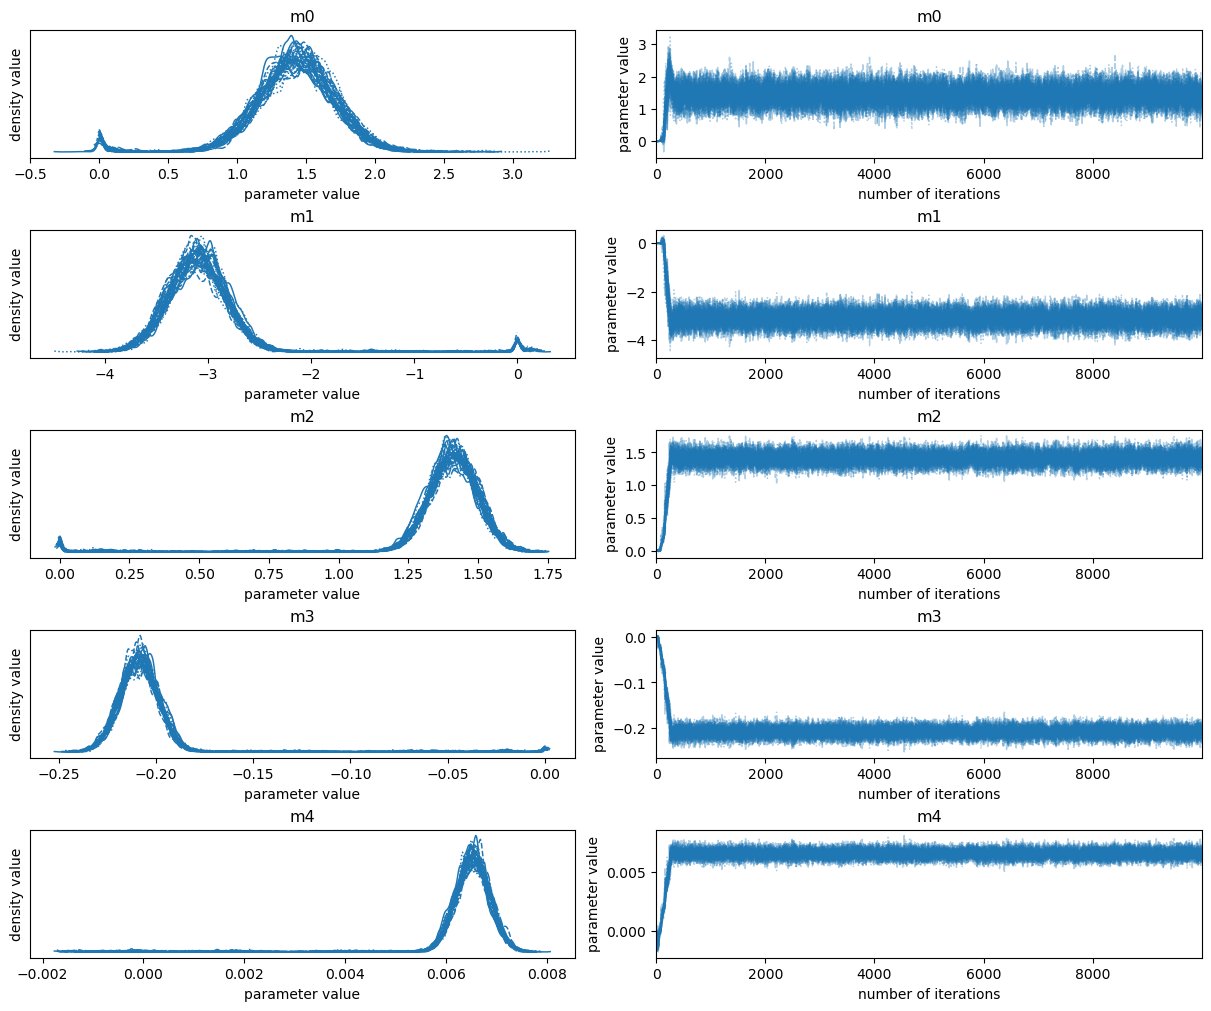

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

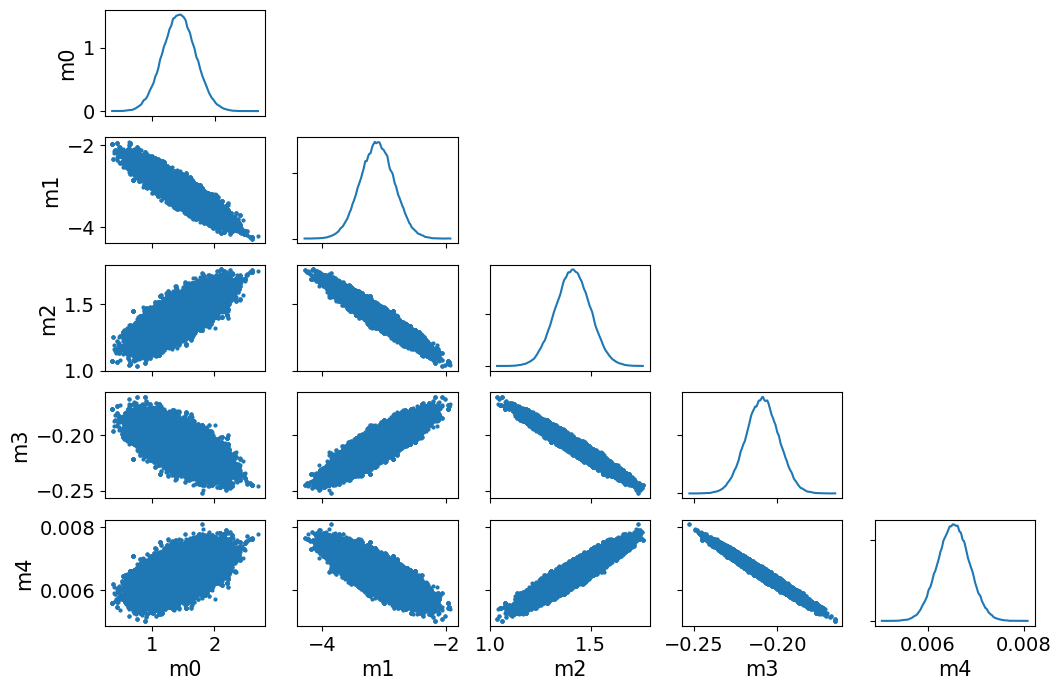

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

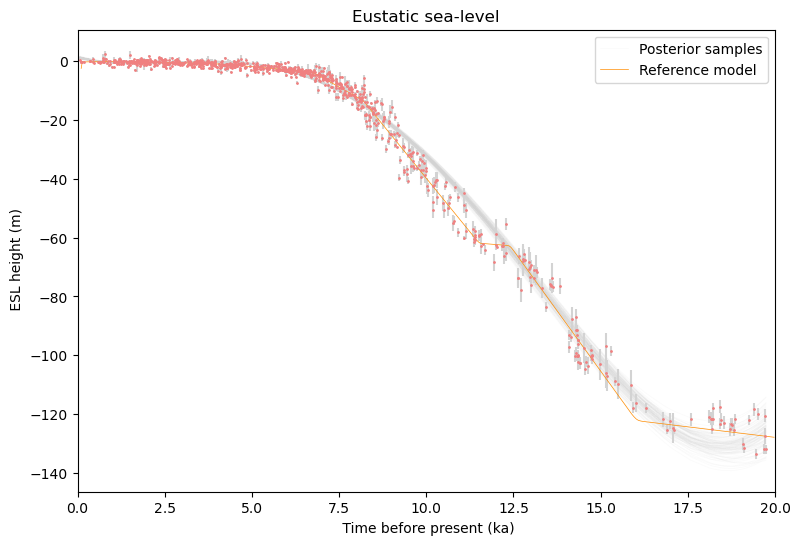

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.435 [  1.006,   1.867]
 m1  -3.110 [ -3.559,  -2.658]
 m2   1.412 [  1.269,   1.552]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.82557951e-02 -6.42090325e-02  1.70757859e-02 -1.64084592e-03
   4.87350333e-05]
 [-6.42090325e-02  7.56416118e-02 -2.26273362e-02  2.34290247e-03
  -7.26429013e-05]
 [ 1.70757859e-02 -2.26273362e-02  7.43002638e-03 -8.23184711e-04
   2.65743374e-05]
 [-1.64084592e-03  2.34290247e-03 -8.23184711e-04  9.62846916e-05
  -3.21566867e-06]
 [ 4.87350333e-05 -7.26429013e-05  2.65743374e-05 -3.21566867e-06
   1.10299723e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2612
    m1  0.2750
    m2  0.0862
    m3  0.0098
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                           | 0/10000 [00:00<?, ?it/s]

  0%|                                                                 | 14/10000 [00:00<01:12, 137.74it/s]

  0%|▏                                                                | 29/10000 [00:00<01:11, 139.50it/s]

  0%|▎                                                                | 43/10000 [00:00<01:11, 139.71it/s]

  1%|▎                                                                | 57/10000 [00:00<01:11, 139.64it/s]

  1%|▍                                                                | 71/10000 [00:00<01:11, 139.34it/s]

  1%|▌                                                                | 85/10000 [00:00<01:11, 139.55it/s]

  1%|▋                                                                | 99/10000 [00:00<01:10, 139.48it/s]

  1%|▋                                                               | 113/10000 [00:00<01:10, 139.49it/s]

  1%|▊                                                               | 127/10000 [00:00<01:11, 138.72it/s]

  1%|▉                                                               | 141/10000 [00:01<01:10, 138.94it/s]

  2%|▉                                                               | 155/10000 [00:01<01:10, 139.02it/s]

  2%|█                                                               | 169/10000 [00:01<01:10, 139.14it/s]

  2%|█▏                                                              | 183/10000 [00:01<01:10, 139.35it/s]

  2%|█▎                                                              | 198/10000 [00:01<01:10, 139.73it/s]

  2%|█▎                                                              | 212/10000 [00:01<01:10, 139.67it/s]

  2%|█▍                                                              | 226/10000 [00:01<01:09, 139.73it/s]

  2%|█▌                                                              | 241/10000 [00:01<01:09, 140.65it/s]

  3%|█▋                                                              | 256/10000 [00:01<01:10, 138.09it/s]

  3%|█▋                                                              | 270/10000 [00:01<01:17, 125.66it/s]

  3%|█▊                                                              | 285/10000 [00:02<01:13, 132.26it/s]

  3%|█▉                                                              | 301/10000 [00:02<01:09, 138.62it/s]

  3%|██                                                              | 317/10000 [00:02<01:07, 143.18it/s]

  3%|██▏                                                             | 333/10000 [00:02<01:05, 146.88it/s]

  3%|██▏                                                             | 349/10000 [00:02<01:04, 149.05it/s]

  4%|██▎                                                             | 365/10000 [00:02<01:03, 151.41it/s]

  4%|██▍                                                             | 381/10000 [00:02<01:05, 147.46it/s]

  4%|██▌                                                             | 396/10000 [00:02<01:04, 147.78it/s]

  4%|██▋                                                             | 411/10000 [00:02<01:12, 131.72it/s]

  4%|██▋                                                             | 427/10000 [00:03<01:09, 138.33it/s]

  4%|██▊                                                             | 443/10000 [00:03<01:06, 142.94it/s]

  5%|██▉                                                             | 459/10000 [00:03<01:04, 146.88it/s]

  5%|███                                                             | 476/10000 [00:03<01:02, 151.96it/s]

  5%|███▏                                                            | 492/10000 [00:03<01:02, 151.48it/s]

  5%|███▎                                                            | 508/10000 [00:03<01:02, 152.84it/s]

  5%|███▎                                                            | 524/10000 [00:03<01:01, 154.67it/s]

  5%|███▍                                                            | 540/10000 [00:03<01:03, 149.41it/s]

  6%|███▌                                                            | 556/10000 [00:03<01:02, 152.25it/s]

  6%|███▋                                                            | 572/10000 [00:03<01:02, 151.16it/s]

  6%|███▊                                                            | 588/10000 [00:04<01:01, 152.50it/s]

  6%|███▊                                                            | 604/10000 [00:04<01:01, 153.00it/s]

  6%|███▉                                                            | 620/10000 [00:04<01:02, 150.65it/s]

  6%|████                                                            | 636/10000 [00:04<01:01, 151.23it/s]

  7%|████▏                                                           | 652/10000 [00:04<01:01, 151.43it/s]

  7%|████▎                                                           | 668/10000 [00:04<01:00, 153.42it/s]

  7%|████▍                                                           | 684/10000 [00:04<01:00, 153.97it/s]

  7%|████▍                                                           | 700/10000 [00:04<01:00, 154.71it/s]

  7%|████▌                                                           | 716/10000 [00:04<00:59, 155.14it/s]

  7%|████▋                                                           | 732/10000 [00:05<00:59, 155.87it/s]

  7%|████▊                                                           | 748/10000 [00:05<00:59, 155.63it/s]

  8%|████▉                                                           | 764/10000 [00:05<00:59, 154.10it/s]

  8%|████▉                                                           | 780/10000 [00:05<00:59, 155.10it/s]

  8%|█████                                                           | 796/10000 [00:05<00:59, 154.77it/s]

  8%|█████▏                                                          | 812/10000 [00:05<00:58, 155.91it/s]

  8%|█████▎                                                          | 828/10000 [00:05<00:59, 154.90it/s]

  8%|█████▍                                                          | 844/10000 [00:05<00:59, 154.84it/s]

  9%|█████▌                                                          | 860/10000 [00:05<00:59, 153.76it/s]

  9%|█████▌                                                          | 876/10000 [00:05<00:59, 153.58it/s]

  9%|█████▋                                                          | 892/10000 [00:06<00:59, 153.74it/s]

  9%|█████▊                                                          | 908/10000 [00:06<00:58, 155.12it/s]

  9%|█████▉                                                          | 924/10000 [00:06<00:58, 156.04it/s]

  9%|██████                                                          | 940/10000 [00:06<01:00, 150.81it/s]

 10%|██████                                                          | 956/10000 [00:06<00:59, 152.79it/s]

 10%|██████▏                                                         | 972/10000 [00:06<00:58, 153.99it/s]

 10%|██████▎                                                         | 988/10000 [00:06<00:57, 155.44it/s]

 10%|██████▎                                                        | 1004/10000 [00:06<00:57, 156.65it/s]

 10%|██████▍                                                        | 1021/10000 [00:06<00:56, 157.97it/s]

 10%|██████▌                                                        | 1037/10000 [00:07<00:57, 156.77it/s]

 11%|██████▋                                                        | 1053/10000 [00:07<00:57, 156.43it/s]

 11%|██████▋                                                        | 1069/10000 [00:07<00:57, 156.08it/s]

 11%|██████▊                                                        | 1085/10000 [00:07<00:56, 156.56it/s]

 11%|██████▉                                                        | 1101/10000 [00:07<00:56, 156.29it/s]

 11%|███████                                                        | 1118/10000 [00:07<00:56, 157.73it/s]

 11%|███████▏                                                       | 1134/10000 [00:07<00:56, 157.52it/s]

 12%|███████▏                                                       | 1150/10000 [00:07<00:56, 157.83it/s]

 12%|███████▎                                                       | 1166/10000 [00:07<00:56, 156.37it/s]

 12%|███████▍                                                       | 1182/10000 [00:07<01:05, 135.50it/s]

 12%|███████▌                                                       | 1198/10000 [00:08<01:03, 139.57it/s]

 12%|███████▋                                                       | 1214/10000 [00:08<01:00, 144.73it/s]

 12%|███████▋                                                       | 1230/10000 [00:08<00:59, 147.08it/s]

 12%|███████▊                                                       | 1246/10000 [00:08<00:58, 148.96it/s]

 13%|███████▉                                                       | 1262/10000 [00:08<00:58, 149.27it/s]

 13%|████████                                                       | 1278/10000 [00:08<00:57, 151.79it/s]

 13%|████████▏                                                      | 1294/10000 [00:08<00:56, 153.15it/s]

 13%|████████▎                                                      | 1310/10000 [00:08<00:57, 150.73it/s]

 13%|████████▎                                                      | 1326/10000 [00:08<00:57, 150.78it/s]

 13%|████████▍                                                      | 1342/10000 [00:09<00:58, 148.88it/s]

 14%|████████▌                                                      | 1358/10000 [00:09<00:57, 150.70it/s]

 14%|████████▋                                                      | 1374/10000 [00:09<00:57, 151.13it/s]

 14%|████████▊                                                      | 1390/10000 [00:09<00:56, 153.13it/s]

 14%|████████▊                                                      | 1406/10000 [00:09<00:55, 153.86it/s]

 14%|████████▉                                                      | 1422/10000 [00:09<00:56, 151.36it/s]

 14%|█████████                                                      | 1438/10000 [00:09<00:56, 151.58it/s]

 15%|█████████▏                                                     | 1454/10000 [00:09<00:56, 151.89it/s]

 15%|█████████▎                                                     | 1470/10000 [00:09<00:56, 151.95it/s]

 15%|█████████▎                                                     | 1486/10000 [00:09<00:55, 152.04it/s]

 15%|█████████▍                                                     | 1502/10000 [00:10<00:55, 152.11it/s]

 15%|█████████▌                                                     | 1518/10000 [00:10<00:55, 152.41it/s]

 15%|█████████▋                                                     | 1534/10000 [00:10<00:55, 153.84it/s]

 16%|█████████▊                                                     | 1550/10000 [00:10<00:55, 153.20it/s]

 16%|█████████▊                                                     | 1566/10000 [00:10<00:54, 153.75it/s]

 16%|█████████▉                                                     | 1582/10000 [00:10<00:54, 154.45it/s]

 16%|██████████                                                     | 1598/10000 [00:10<00:54, 154.03it/s]

 16%|██████████▏                                                    | 1614/10000 [00:10<00:54, 154.38it/s]

 16%|██████████▎                                                    | 1630/10000 [00:10<00:54, 153.11it/s]

 16%|██████████▎                                                    | 1646/10000 [00:11<00:54, 152.34it/s]

 17%|██████████▍                                                    | 1662/10000 [00:11<00:54, 152.28it/s]

 17%|██████████▌                                                    | 1678/10000 [00:11<00:54, 152.85it/s]

 17%|██████████▋                                                    | 1694/10000 [00:11<00:54, 153.65it/s]

 17%|██████████▊                                                    | 1710/10000 [00:11<00:53, 153.83it/s]

 17%|██████████▊                                                    | 1726/10000 [00:11<00:54, 153.13it/s]

 17%|██████████▉                                                    | 1742/10000 [00:11<00:53, 154.14it/s]

 18%|███████████                                                    | 1758/10000 [00:11<00:53, 154.57it/s]

 18%|███████████▏                                                   | 1774/10000 [00:11<00:53, 154.50it/s]

 18%|███████████▎                                                   | 1790/10000 [00:11<00:52, 154.93it/s]

 18%|███████████▍                                                   | 1806/10000 [00:12<00:53, 154.23it/s]

 18%|███████████▍                                                   | 1822/10000 [00:12<00:52, 155.09it/s]

 18%|███████████▌                                                   | 1838/10000 [00:12<00:52, 155.75it/s]

 19%|███████████▋                                                   | 1854/10000 [00:12<00:52, 155.49it/s]

 19%|███████████▊                                                   | 1870/10000 [00:12<00:55, 145.18it/s]

 19%|███████████▉                                                   | 1885/10000 [00:12<01:04, 126.02it/s]

 19%|███████████▉                                                   | 1901/10000 [00:12<01:00, 133.37it/s]

 19%|████████████                                                   | 1917/10000 [00:12<00:57, 140.33it/s]

 19%|████████████▏                                                  | 1934/10000 [00:12<00:55, 146.23it/s]

 20%|████████████▎                                                  | 1950/10000 [00:13<00:53, 149.29it/s]

 20%|████████████▍                                                  | 1966/10000 [00:13<00:53, 151.52it/s]

 20%|████████████▍                                                  | 1982/10000 [00:13<00:52, 151.51it/s]

 20%|████████████▌                                                  | 1998/10000 [00:13<00:52, 151.16it/s]

 20%|████████████▋                                                  | 2015/10000 [00:13<00:51, 153.77it/s]

 20%|████████████▊                                                  | 2031/10000 [00:13<00:52, 151.11it/s]

 20%|████████████▉                                                  | 2047/10000 [00:13<00:52, 151.15it/s]

 21%|████████████▉                                                  | 2063/10000 [00:13<00:51, 153.08it/s]

 21%|█████████████                                                  | 2079/10000 [00:13<00:51, 153.59it/s]

 21%|█████████████▏                                                 | 2095/10000 [00:14<00:51, 152.87it/s]

 21%|█████████████▎                                                 | 2111/10000 [00:14<00:51, 154.39it/s]

 21%|█████████████▍                                                 | 2127/10000 [00:14<00:51, 154.10it/s]

 21%|█████████████▌                                                 | 2143/10000 [00:14<00:51, 152.72it/s]

 22%|█████████████▌                                                 | 2159/10000 [00:14<00:51, 153.32it/s]

 22%|█████████████▋                                                 | 2175/10000 [00:14<00:50, 153.75it/s]

 22%|█████████████▊                                                 | 2191/10000 [00:14<00:50, 154.14it/s]

 22%|█████████████▉                                                 | 2207/10000 [00:14<00:50, 154.19it/s]

 22%|██████████████                                                 | 2223/10000 [00:14<00:50, 154.68it/s]

 22%|██████████████                                                 | 2239/10000 [00:14<00:50, 154.45it/s]

 23%|██████████████▏                                                | 2255/10000 [00:15<00:50, 154.08it/s]

 23%|██████████████▎                                                | 2271/10000 [00:15<00:50, 154.22it/s]

 23%|██████████████▍                                                | 2287/10000 [00:15<00:50, 154.17it/s]

 23%|██████████████▌                                                | 2303/10000 [00:15<00:49, 154.64it/s]

 23%|██████████████▌                                                | 2319/10000 [00:15<00:49, 154.34it/s]

 23%|██████████████▋                                                | 2335/10000 [00:15<00:49, 153.49it/s]

 24%|██████████████▊                                                | 2351/10000 [00:15<00:50, 152.62it/s]

 24%|██████████████▉                                                | 2367/10000 [00:15<00:50, 152.20it/s]

 24%|███████████████                                                | 2383/10000 [00:15<00:49, 152.42it/s]

 24%|███████████████                                                | 2399/10000 [00:15<00:49, 153.66it/s]

 24%|███████████████▏                                               | 2415/10000 [00:16<00:49, 154.60it/s]

 24%|███████████████▎                                               | 2431/10000 [00:16<00:49, 153.62it/s]

 24%|███████████████▍                                               | 2447/10000 [00:16<00:49, 153.83it/s]

 25%|███████████████▌                                               | 2463/10000 [00:16<00:48, 154.51it/s]

 25%|███████████████▌                                               | 2479/10000 [00:16<00:48, 154.78it/s]

 25%|███████████████▋                                               | 2495/10000 [00:16<00:48, 155.83it/s]

 25%|███████████████▊                                               | 2511/10000 [00:16<00:48, 155.20it/s]

 25%|███████████████▉                                               | 2527/10000 [00:16<00:48, 155.03it/s]

 25%|████████████████                                               | 2543/10000 [00:16<00:47, 155.50it/s]

 26%|████████████████                                               | 2559/10000 [00:17<00:47, 155.67it/s]

 26%|████████████████▏                                              | 2575/10000 [00:17<00:47, 155.69it/s]

 26%|████████████████▎                                              | 2591/10000 [00:17<00:47, 155.00it/s]

 26%|████████████████▍                                              | 2607/10000 [00:17<00:48, 153.33it/s]

 26%|████████████████▌                                              | 2623/10000 [00:17<00:48, 152.12it/s]

 26%|████████████████▋                                              | 2640/10000 [00:17<00:47, 154.70it/s]

 27%|████████████████▋                                              | 2656/10000 [00:17<00:47, 155.39it/s]

 27%|████████████████▊                                              | 2672/10000 [00:17<00:47, 155.38it/s]

 27%|████████████████▉                                              | 2688/10000 [00:17<00:47, 154.73it/s]

 27%|█████████████████                                              | 2704/10000 [00:17<00:47, 154.42it/s]

 27%|█████████████████▏                                             | 2720/10000 [00:18<00:46, 155.53it/s]

 27%|█████████████████▏                                             | 2736/10000 [00:18<00:46, 155.81it/s]

 28%|█████████████████▎                                             | 2752/10000 [00:18<00:46, 155.56it/s]

 28%|█████████████████▍                                             | 2768/10000 [00:18<00:46, 155.34it/s]

 28%|█████████████████▌                                             | 2784/10000 [00:18<00:46, 154.17it/s]

 28%|█████████████████▋                                             | 2800/10000 [00:18<00:46, 155.27it/s]

 28%|█████████████████▋                                             | 2816/10000 [00:18<00:46, 156.08it/s]

 28%|█████████████████▊                                             | 2833/10000 [00:18<00:45, 157.64it/s]

 28%|█████████████████▉                                             | 2849/10000 [00:18<00:45, 158.29it/s]

 29%|██████████████████                                             | 2866/10000 [00:18<00:44, 159.93it/s]

 29%|██████████████████▏                                            | 2882/10000 [00:19<00:44, 159.20it/s]

 29%|██████████████████▎                                            | 2899/10000 [00:19<00:44, 160.30it/s]

 29%|██████████████████▎                                            | 2916/10000 [00:19<00:44, 159.97it/s]

 29%|██████████████████▍                                            | 2932/10000 [00:19<00:44, 158.38it/s]

 29%|██████████████████▌                                            | 2948/10000 [00:19<00:44, 158.20it/s]

 30%|██████████████████▋                                            | 2964/10000 [00:19<00:44, 157.83it/s]

 30%|██████████████████▊                                            | 2980/10000 [00:19<00:44, 158.00it/s]

 30%|██████████████████▊                                            | 2996/10000 [00:19<00:44, 156.16it/s]

 30%|██████████████████▉                                            | 3012/10000 [00:19<00:44, 155.50it/s]

 30%|███████████████████                                            | 3028/10000 [00:20<00:44, 155.56it/s]

 30%|███████████████████▏                                           | 3044/10000 [00:20<00:44, 154.98it/s]

 31%|███████████████████▎                                           | 3060/10000 [00:20<00:45, 153.43it/s]

 31%|███████████████████▍                                           | 3076/10000 [00:20<00:45, 153.59it/s]

 31%|███████████████████▍                                           | 3092/10000 [00:20<00:45, 152.98it/s]

 31%|███████████████████▌                                           | 3108/10000 [00:20<00:44, 153.42it/s]

 31%|███████████████████▋                                           | 3125/10000 [00:20<00:44, 155.32it/s]

 31%|███████████████████▊                                           | 3141/10000 [00:20<00:43, 156.19it/s]

 32%|███████████████████▉                                           | 3157/10000 [00:20<00:43, 156.03it/s]

 32%|███████████████████▉                                           | 3173/10000 [00:20<00:44, 152.95it/s]

 32%|████████████████████                                           | 3189/10000 [00:21<00:44, 153.25it/s]

 32%|████████████████████▏                                          | 3205/10000 [00:21<00:44, 154.05it/s]

 32%|████████████████████▎                                          | 3222/10000 [00:21<00:43, 155.76it/s]

 32%|████████████████████▍                                          | 3238/10000 [00:21<00:43, 156.98it/s]

 33%|████████████████████▌                                          | 3254/10000 [00:21<00:43, 156.01it/s]

 33%|████████████████████▌                                          | 3270/10000 [00:21<00:43, 155.23it/s]

 33%|████████████████████▋                                          | 3286/10000 [00:21<00:43, 154.55it/s]

 33%|████████████████████▊                                          | 3302/10000 [00:21<00:43, 154.91it/s]

 33%|████████████████████▉                                          | 3318/10000 [00:21<00:43, 153.47it/s]

 33%|█████████████████████                                          | 3334/10000 [00:21<00:43, 154.39it/s]

 34%|█████████████████████                                          | 3350/10000 [00:22<00:42, 155.47it/s]

 34%|█████████████████████▏                                         | 3366/10000 [00:22<00:42, 156.08it/s]

 34%|█████████████████████▎                                         | 3383/10000 [00:22<00:41, 157.81it/s]

 34%|█████████████████████▍                                         | 3399/10000 [00:22<00:42, 156.72it/s]

 34%|█████████████████████▌                                         | 3415/10000 [00:22<00:42, 155.24it/s]

 34%|█████████████████████▌                                         | 3431/10000 [00:22<00:42, 153.12it/s]

 34%|█████████████████████▋                                         | 3447/10000 [00:22<00:43, 152.28it/s]

 35%|█████████████████████▊                                         | 3463/10000 [00:22<00:42, 153.74it/s]

 35%|█████████████████████▉                                         | 3479/10000 [00:22<00:42, 154.48it/s]

 35%|██████████████████████                                         | 3495/10000 [00:23<00:42, 153.00it/s]

 35%|██████████████████████                                         | 3511/10000 [00:23<00:42, 151.97it/s]

 35%|██████████████████████▏                                        | 3527/10000 [00:23<00:42, 152.69it/s]

 35%|██████████████████████▎                                        | 3543/10000 [00:23<00:42, 152.80it/s]

 36%|██████████████████████▍                                        | 3559/10000 [00:23<00:42, 153.18it/s]

 36%|██████████████████████▌                                        | 3575/10000 [00:23<00:41, 153.36it/s]

 36%|██████████████████████▌                                        | 3591/10000 [00:23<00:41, 153.33it/s]

 36%|██████████████████████▋                                        | 3607/10000 [00:23<00:41, 154.19it/s]

 36%|██████████████████████▊                                        | 3623/10000 [00:23<00:41, 155.53it/s]

 36%|██████████████████████▉                                        | 3640/10000 [00:23<00:40, 157.02it/s]

 37%|███████████████████████                                        | 3656/10000 [00:24<00:40, 157.16it/s]

 37%|███████████████████████▏                                       | 3672/10000 [00:24<00:40, 156.53it/s]

 37%|███████████████████████▏                                       | 3688/10000 [00:24<00:40, 155.74it/s]

 37%|███████████████████████▎                                       | 3704/10000 [00:24<00:40, 156.13it/s]

 37%|███████████████████████▍                                       | 3720/10000 [00:24<00:40, 154.83it/s]

 37%|███████████████████████▌                                       | 3736/10000 [00:24<00:40, 155.20it/s]

 38%|███████████████████████▋                                       | 3752/10000 [00:24<00:40, 154.72it/s]

 38%|███████████████████████▋                                       | 3768/10000 [00:24<00:40, 154.60it/s]

 38%|███████████████████████▊                                       | 3784/10000 [00:24<00:40, 154.24it/s]

 38%|███████████████████████▉                                       | 3800/10000 [00:25<00:39, 155.45it/s]

 38%|████████████████████████                                       | 3816/10000 [00:25<00:40, 154.32it/s]

 38%|████████████████████████▏                                      | 3832/10000 [00:25<00:40, 153.43it/s]

 38%|████████████████████████▏                                      | 3848/10000 [00:25<00:40, 153.66it/s]

 39%|████████████████████████▎                                      | 3864/10000 [00:25<00:40, 152.80it/s]

 39%|████████████████████████▍                                      | 3880/10000 [00:25<00:40, 152.35it/s]

 39%|████████████████████████▌                                      | 3896/10000 [00:25<00:39, 154.13it/s]

 39%|████████████████████████▋                                      | 3912/10000 [00:25<00:39, 155.63it/s]

 39%|████████████████████████▋                                      | 3928/10000 [00:25<00:38, 155.82it/s]

 39%|████████████████████████▊                                      | 3945/10000 [00:25<00:38, 157.27it/s]

 40%|████████████████████████▉                                      | 3961/10000 [00:26<00:38, 157.32it/s]

 40%|█████████████████████████                                      | 3977/10000 [00:26<00:39, 154.31it/s]

 40%|█████████████████████████▏                                     | 3993/10000 [00:26<00:38, 154.06it/s]

 40%|█████████████████████████▎                                     | 4009/10000 [00:26<00:39, 153.37it/s]

 40%|█████████████████████████▎                                     | 4025/10000 [00:26<00:38, 153.59it/s]

 40%|█████████████████████████▍                                     | 4042/10000 [00:26<00:38, 155.89it/s]

 41%|█████████████████████████▌                                     | 4059/10000 [00:26<00:37, 157.25it/s]

 41%|█████████████████████████▋                                     | 4075/10000 [00:26<00:37, 157.92it/s]

 41%|█████████████████████████▊                                     | 4091/10000 [00:26<00:37, 158.11it/s]

 41%|█████████████████████████▊                                     | 4107/10000 [00:26<00:37, 158.58it/s]

 41%|█████████████████████████▉                                     | 4123/10000 [00:27<00:37, 157.79it/s]

 41%|██████████████████████████                                     | 4139/10000 [00:27<00:37, 157.25it/s]

 42%|██████████████████████████▏                                    | 4155/10000 [00:27<00:37, 156.47it/s]

 42%|██████████████████████████▎                                    | 4171/10000 [00:27<00:37, 154.79it/s]

 42%|██████████████████████████▍                                    | 4187/10000 [00:27<00:37, 154.87it/s]

 42%|██████████████████████████▍                                    | 4203/10000 [00:27<00:37, 155.76it/s]

 42%|██████████████████████████▌                                    | 4219/10000 [00:27<00:36, 156.50it/s]

 42%|██████████████████████████▋                                    | 4235/10000 [00:27<00:36, 156.48it/s]

 43%|██████████████████████████▊                                    | 4251/10000 [00:27<00:36, 155.61it/s]

 43%|██████████████████████████▉                                    | 4267/10000 [00:28<00:36, 155.75it/s]

 43%|██████████████████████████▉                                    | 4283/10000 [00:28<00:36, 155.80it/s]

 43%|███████████████████████████                                    | 4299/10000 [00:28<00:36, 156.11it/s]

 43%|███████████████████████████▏                                   | 4315/10000 [00:28<00:36, 157.06it/s]

 43%|███████████████████████████▎                                   | 4331/10000 [00:28<00:36, 157.11it/s]

 43%|███████████████████████████▍                                   | 4347/10000 [00:28<00:36, 156.27it/s]

 44%|███████████████████████████▍                                   | 4363/10000 [00:28<00:36, 156.41it/s]

 44%|███████████████████████████▌                                   | 4379/10000 [00:28<00:35, 156.27it/s]

 44%|███████████████████████████▋                                   | 4395/10000 [00:28<00:35, 157.30it/s]

 44%|███████████████████████████▊                                   | 4412/10000 [00:28<00:35, 158.52it/s]

 44%|███████████████████████████▉                                   | 4428/10000 [00:29<00:35, 157.97it/s]

 44%|████████████████████████████                                   | 4445/10000 [00:29<00:35, 158.33it/s]

 45%|████████████████████████████                                   | 4461/10000 [00:29<00:35, 158.08it/s]

 45%|████████████████████████████▏                                  | 4477/10000 [00:29<00:35, 156.87it/s]

 45%|████████████████████████████▎                                  | 4493/10000 [00:29<00:35, 156.93it/s]

 45%|████████████████████████████▍                                  | 4509/10000 [00:29<00:35, 155.55it/s]

 45%|████████████████████████████▌                                  | 4525/10000 [00:29<00:35, 153.60it/s]

 45%|████████████████████████████▌                                  | 4541/10000 [00:29<00:35, 152.87it/s]

 46%|████████████████████████████▋                                  | 4557/10000 [00:29<00:35, 153.42it/s]

 46%|████████████████████████████▊                                  | 4573/10000 [00:29<00:35, 153.68it/s]

 46%|████████████████████████████▉                                  | 4589/10000 [00:30<00:35, 152.09it/s]

 46%|█████████████████████████████                                  | 4605/10000 [00:30<00:46, 115.85it/s]

 46%|█████████████████████████████                                  | 4621/10000 [00:30<00:43, 124.66it/s]

 46%|█████████████████████████████▏                                 | 4637/10000 [00:30<00:40, 131.95it/s]

 47%|█████████████████████████████▎                                 | 4653/10000 [00:30<00:38, 137.81it/s]

 47%|█████████████████████████████▍                                 | 4669/10000 [00:30<00:37, 141.93it/s]

 47%|█████████████████████████████▌                                 | 4685/10000 [00:30<00:36, 146.01it/s]

 47%|█████████████████████████████▌                                 | 4701/10000 [00:30<00:35, 147.88it/s]

 47%|█████████████████████████████▋                                 | 4717/10000 [00:31<00:35, 148.08it/s]

 47%|█████████████████████████████▊                                 | 4733/10000 [00:31<00:35, 149.28it/s]

 47%|█████████████████████████████▉                                 | 4749/10000 [00:31<00:35, 149.71it/s]

 48%|██████████████████████████████                                 | 4765/10000 [00:31<00:34, 150.48it/s]

 48%|██████████████████████████████                                 | 4781/10000 [00:31<00:35, 146.35it/s]

 48%|██████████████████████████████▏                                | 4797/10000 [00:31<00:35, 148.24it/s]

 48%|██████████████████████████████▎                                | 4813/10000 [00:31<00:34, 150.21it/s]

 48%|██████████████████████████████▍                                | 4829/10000 [00:31<00:33, 152.76it/s]

 48%|██████████████████████████████▌                                | 4845/10000 [00:31<00:33, 153.79it/s]

 49%|██████████████████████████████▌                                | 4861/10000 [00:31<00:33, 152.91it/s]

 49%|██████████████████████████████▋                                | 4877/10000 [00:32<00:33, 152.52it/s]

 49%|██████████████████████████████▊                                | 4893/10000 [00:32<00:33, 153.46it/s]

 49%|██████████████████████████████▉                                | 4909/10000 [00:32<00:33, 153.87it/s]

 49%|███████████████████████████████                                | 4925/10000 [00:32<00:32, 154.21it/s]

 49%|███████████████████████████████▏                               | 4942/10000 [00:32<00:32, 156.80it/s]

 50%|███████████████████████████████▏                               | 4958/10000 [00:32<00:32, 156.32it/s]

 50%|███████████████████████████████▎                               | 4974/10000 [00:32<00:32, 155.34it/s]

 50%|███████████████████████████████▍                               | 4990/10000 [00:32<00:32, 154.94it/s]

 50%|███████████████████████████████▌                               | 5006/10000 [00:32<00:32, 155.73it/s]

 50%|███████████████████████████████▋                               | 5022/10000 [00:33<00:32, 155.41it/s]

 50%|███████████████████████████████▋                               | 5038/10000 [00:33<00:31, 155.48it/s]

 51%|███████████████████████████████▊                               | 5054/10000 [00:33<00:31, 154.84it/s]

 51%|███████████████████████████████▉                               | 5070/10000 [00:33<00:32, 153.47it/s]

 51%|████████████████████████████████                               | 5086/10000 [00:33<00:31, 154.80it/s]

 51%|████████████████████████████████▏                              | 5102/10000 [00:33<00:31, 155.33it/s]

 51%|████████████████████████████████▏                              | 5118/10000 [00:33<00:31, 155.45it/s]

 51%|████████████████████████████████▎                              | 5134/10000 [00:33<00:31, 155.75it/s]

 52%|████████████████████████████████▍                              | 5150/10000 [00:33<00:31, 155.41it/s]

 52%|████████████████████████████████▌                              | 5166/10000 [00:33<00:30, 156.76it/s]

 52%|████████████████████████████████▋                              | 5182/10000 [00:34<00:30, 157.02it/s]

 52%|████████████████████████████████▋                              | 5198/10000 [00:34<00:30, 156.91it/s]

 52%|████████████████████████████████▊                              | 5214/10000 [00:34<00:30, 156.11it/s]

 52%|████████████████████████████████▉                              | 5230/10000 [00:34<00:30, 154.85it/s]

 52%|█████████████████████████████████                              | 5246/10000 [00:34<00:30, 154.83it/s]

 53%|█████████████████████████████████▏                             | 5262/10000 [00:34<00:30, 155.10it/s]

 53%|█████████████████████████████████▎                             | 5278/10000 [00:34<00:30, 155.06it/s]

 53%|█████████████████████████████████▎                             | 5294/10000 [00:34<00:30, 153.12it/s]

 53%|█████████████████████████████████▍                             | 5310/10000 [00:34<00:30, 152.68it/s]

 53%|█████████████████████████████████▌                             | 5326/10000 [00:34<00:30, 154.03it/s]

 53%|█████████████████████████████████▋                             | 5342/10000 [00:35<00:29, 155.47it/s]

 54%|█████████████████████████████████▊                             | 5359/10000 [00:35<00:29, 157.09it/s]

 54%|█████████████████████████████████▊                             | 5375/10000 [00:35<00:29, 156.74it/s]

 54%|█████████████████████████████████▉                             | 5392/10000 [00:35<00:29, 158.73it/s]

 54%|██████████████████████████████████                             | 5408/10000 [00:35<00:29, 158.23it/s]

 54%|██████████████████████████████████▏                            | 5424/10000 [00:35<00:29, 157.37it/s]

 54%|██████████████████████████████████▎                            | 5440/10000 [00:35<00:29, 156.72it/s]

 55%|██████████████████████████████████▎                            | 5456/10000 [00:35<00:29, 156.25it/s]

 55%|██████████████████████████████████▍                            | 5472/10000 [00:35<00:29, 155.37it/s]

 55%|██████████████████████████████████▌                            | 5488/10000 [00:36<00:29, 155.45it/s]

 55%|██████████████████████████████████▋                            | 5504/10000 [00:36<00:28, 156.35it/s]

 55%|██████████████████████████████████▊                            | 5520/10000 [00:36<00:28, 155.99it/s]

 55%|██████████████████████████████████▉                            | 5536/10000 [00:36<00:28, 155.13it/s]

 56%|██████████████████████████████████▉                            | 5552/10000 [00:36<00:28, 155.04it/s]

 56%|███████████████████████████████████                            | 5568/10000 [00:36<00:28, 153.83it/s]

 56%|███████████████████████████████████▏                           | 5584/10000 [00:36<00:28, 152.60it/s]

 56%|███████████████████████████████████▎                           | 5600/10000 [00:36<00:28, 153.64it/s]

 56%|███████████████████████████████████▍                           | 5616/10000 [00:36<00:28, 153.86it/s]

 56%|███████████████████████████████████▍                           | 5632/10000 [00:36<00:28, 152.27it/s]

 56%|███████████████████████████████████▌                           | 5648/10000 [00:37<00:28, 151.76it/s]

 57%|███████████████████████████████████▋                           | 5664/10000 [00:37<00:28, 152.88it/s]

 57%|███████████████████████████████████▊                           | 5680/10000 [00:37<00:27, 154.30it/s]

 57%|███████████████████████████████████▉                           | 5696/10000 [00:37<00:27, 155.00it/s]

 57%|███████████████████████████████████▉                           | 5712/10000 [00:37<00:27, 155.39it/s]

 57%|████████████████████████████████████                           | 5728/10000 [00:37<00:27, 156.64it/s]

 57%|████████████████████████████████████▏                          | 5744/10000 [00:37<00:27, 157.20it/s]

 58%|████████████████████████████████████▎                          | 5760/10000 [00:37<00:27, 156.25it/s]

 58%|████████████████████████████████████▍                          | 5776/10000 [00:37<00:26, 156.66it/s]

 58%|████████████████████████████████████▍                          | 5792/10000 [00:37<00:27, 155.21it/s]

 58%|████████████████████████████████████▌                          | 5808/10000 [00:38<00:27, 154.24it/s]

 58%|████████████████████████████████████▋                          | 5824/10000 [00:38<00:26, 155.69it/s]

 58%|████████████████████████████████████▊                          | 5840/10000 [00:38<00:26, 156.60it/s]

 59%|████████████████████████████████████▉                          | 5856/10000 [00:38<00:26, 156.57it/s]

 59%|████████████████████████████████████▉                          | 5872/10000 [00:38<00:26, 155.71it/s]

 59%|█████████████████████████████████████                          | 5888/10000 [00:38<00:26, 155.24it/s]

 59%|█████████████████████████████████████▏                         | 5904/10000 [00:38<00:26, 156.28it/s]

 59%|█████████████████████████████████████▎                         | 5920/10000 [00:38<00:26, 156.72it/s]

 59%|█████████████████████████████████████▍                         | 5936/10000 [00:38<00:26, 156.16it/s]

 60%|█████████████████████████████████████▍                         | 5952/10000 [00:38<00:26, 154.99it/s]

 60%|█████████████████████████████████████▌                         | 5968/10000 [00:39<00:26, 153.20it/s]

 60%|█████████████████████████████████████▋                         | 5984/10000 [00:39<00:26, 154.26it/s]

 60%|█████████████████████████████████████▊                         | 6000/10000 [00:39<00:26, 153.78it/s]

 60%|█████████████████████████████████████▉                         | 6016/10000 [00:39<00:25, 153.85it/s]

 60%|██████████████████████████████████████                         | 6032/10000 [00:39<00:25, 155.04it/s]

 60%|██████████████████████████████████████                         | 6048/10000 [00:39<00:25, 154.91it/s]

 61%|██████████████████████████████████████▏                        | 6064/10000 [00:39<00:25, 154.95it/s]

 61%|██████████████████████████████████████▎                        | 6080/10000 [00:39<00:25, 155.75it/s]

 61%|██████████████████████████████████████▍                        | 6096/10000 [00:39<00:25, 155.46it/s]

 61%|██████████████████████████████████████▌                        | 6112/10000 [00:40<00:25, 155.11it/s]

 61%|██████████████████████████████████████▌                        | 6128/10000 [00:40<00:25, 154.66it/s]

 61%|██████████████████████████████████████▋                        | 6144/10000 [00:40<00:24, 154.59it/s]

 62%|██████████████████████████████████████▊                        | 6160/10000 [00:40<00:24, 155.82it/s]

 62%|██████████████████████████████████████▉                        | 6176/10000 [00:40<00:24, 156.16it/s]

 62%|███████████████████████████████████████                        | 6192/10000 [00:40<00:24, 155.66it/s]

 62%|███████████████████████████████████████                        | 6208/10000 [00:40<00:24, 155.76it/s]

 62%|███████████████████████████████████████▏                       | 6224/10000 [00:40<00:24, 156.44it/s]

 62%|███████████████████████████████████████▎                       | 6241/10000 [00:40<00:23, 158.37it/s]

 63%|███████████████████████████████████████▍                       | 6257/10000 [00:40<00:23, 156.95it/s]

 63%|███████████████████████████████████████▌                       | 6273/10000 [00:41<00:23, 155.81it/s]

 63%|███████████████████████████████████████▌                       | 6289/10000 [00:41<00:23, 155.36it/s]

 63%|███████████████████████████████████████▋                       | 6305/10000 [00:41<00:23, 155.31it/s]

 63%|███████████████████████████████████████▊                       | 6321/10000 [00:41<00:23, 153.94it/s]

 63%|███████████████████████████████████████▉                       | 6337/10000 [00:41<00:23, 154.42it/s]

 64%|████████████████████████████████████████                       | 6354/10000 [00:41<00:23, 156.35it/s]

 64%|████████████████████████████████████████▏                      | 6370/10000 [00:41<00:23, 155.88it/s]

 64%|████████████████████████████████████████▏                      | 6386/10000 [00:41<00:23, 156.90it/s]

 64%|████████████████████████████████████████▎                      | 6402/10000 [00:41<00:23, 155.58it/s]

 64%|████████████████████████████████████████▍                      | 6418/10000 [00:41<00:23, 154.84it/s]

 64%|████████████████████████████████████████▌                      | 6434/10000 [00:42<00:22, 156.14it/s]

 64%|████████████████████████████████████████▋                      | 6450/10000 [00:42<00:22, 156.29it/s]

 65%|████████████████████████████████████████▋                      | 6466/10000 [00:42<00:22, 155.87it/s]

 65%|████████████████████████████████████████▊                      | 6482/10000 [00:42<00:22, 156.37it/s]

 65%|████████████████████████████████████████▉                      | 6498/10000 [00:42<00:22, 156.69it/s]

 65%|█████████████████████████████████████████                      | 6514/10000 [00:42<00:22, 154.94it/s]

 65%|█████████████████████████████████████████▏                     | 6530/10000 [00:42<00:22, 154.62it/s]

 65%|█████████████████████████████████████████▏                     | 6546/10000 [00:42<00:22, 156.04it/s]

 66%|█████████████████████████████████████████▎                     | 6562/10000 [00:42<00:22, 155.73it/s]

 66%|█████████████████████████████████████████▍                     | 6578/10000 [00:43<00:21, 156.01it/s]

 66%|█████████████████████████████████████████▌                     | 6594/10000 [00:43<00:21, 156.99it/s]

 66%|█████████████████████████████████████████▋                     | 6611/10000 [00:43<00:21, 158.07it/s]

 66%|█████████████████████████████████████████▊                     | 6628/10000 [00:43<00:21, 159.24it/s]

 66%|█████████████████████████████████████████▊                     | 6645/10000 [00:43<00:21, 159.73it/s]

 67%|█████████████████████████████████████████▉                     | 6661/10000 [00:43<00:21, 158.59it/s]

 67%|██████████████████████████████████████████                     | 6677/10000 [00:43<00:21, 155.51it/s]

 67%|██████████████████████████████████████████▏                    | 6693/10000 [00:43<00:21, 154.50it/s]

 67%|██████████████████████████████████████████▎                    | 6709/10000 [00:43<00:21, 154.43it/s]

 67%|██████████████████████████████████████████▎                    | 6725/10000 [00:43<00:21, 154.65it/s]

 67%|██████████████████████████████████████████▍                    | 6741/10000 [00:44<00:21, 155.00it/s]

 68%|██████████████████████████████████████████▌                    | 6757/10000 [00:44<00:20, 155.46it/s]

 68%|██████████████████████████████████████████▋                    | 6773/10000 [00:44<00:20, 155.43it/s]

 68%|██████████████████████████████████████████▊                    | 6789/10000 [00:44<00:20, 155.06it/s]

 68%|██████████████████████████████████████████▊                    | 6805/10000 [00:44<00:20, 154.96it/s]

 68%|██████████████████████████████████████████▉                    | 6821/10000 [00:44<00:20, 153.34it/s]

 68%|███████████████████████████████████████████                    | 6837/10000 [00:44<00:20, 152.71it/s]

 69%|███████████████████████████████████████████▏                   | 6853/10000 [00:44<00:20, 152.51it/s]

 69%|███████████████████████████████████████████▎                   | 6869/10000 [00:44<00:20, 152.95it/s]

 69%|███████████████████████████████████████████▍                   | 6885/10000 [00:44<00:20, 154.07it/s]

 69%|███████████████████████████████████████████▍                   | 6901/10000 [00:45<00:20, 153.52it/s]

 69%|███████████████████████████████████████████▌                   | 6917/10000 [00:45<00:20, 153.18it/s]

 69%|███████████████████████████████████████████▋                   | 6933/10000 [00:45<00:20, 153.23it/s]

 69%|███████████████████████████████████████████▊                   | 6949/10000 [00:45<00:19, 152.97it/s]

 70%|███████████████████████████████████████████▉                   | 6965/10000 [00:45<00:19, 154.13it/s]

 70%|███████████████████████████████████████████▉                   | 6981/10000 [00:45<00:19, 155.80it/s]

 70%|████████████████████████████████████████████                   | 6997/10000 [00:45<00:19, 156.84it/s]

 70%|████████████████████████████████████████████▏                  | 7013/10000 [00:45<00:19, 155.60it/s]

 70%|████████████████████████████████████████████▎                  | 7029/10000 [00:45<00:19, 154.98it/s]

 70%|████████████████████████████████████████████▍                  | 7045/10000 [00:46<00:19, 155.33it/s]

 71%|████████████████████████████████████████████▍                  | 7061/10000 [00:46<00:19, 154.66it/s]

 71%|████████████████████████████████████████████▌                  | 7077/10000 [00:46<00:18, 155.94it/s]

 71%|████████████████████████████████████████████▋                  | 7093/10000 [00:46<00:18, 154.76it/s]

 71%|████████████████████████████████████████████▊                  | 7109/10000 [00:46<00:18, 154.00it/s]

 71%|████████████████████████████████████████████▉                  | 7125/10000 [00:46<00:18, 154.14it/s]

 71%|████████████████████████████████████████████▉                  | 7141/10000 [00:46<00:18, 155.15it/s]

 72%|█████████████████████████████████████████████                  | 7157/10000 [00:46<00:18, 154.48it/s]

 72%|█████████████████████████████████████████████▏                 | 7173/10000 [00:46<00:18, 153.42it/s]

 72%|█████████████████████████████████████████████▎                 | 7189/10000 [00:46<00:18, 153.92it/s]

 72%|█████████████████████████████████████████████▍                 | 7205/10000 [00:47<00:18, 154.21it/s]

 72%|█████████████████████████████████████████████▍                 | 7221/10000 [00:47<00:17, 154.84it/s]

 72%|█████████████████████████████████████████████▌                 | 7238/10000 [00:47<00:17, 157.93it/s]

 73%|█████████████████████████████████████████████▋                 | 7254/10000 [00:47<00:17, 156.36it/s]

 73%|█████████████████████████████████████████████▊                 | 7270/10000 [00:47<00:17, 155.44it/s]

 73%|█████████████████████████████████████████████▉                 | 7286/10000 [00:47<00:17, 154.94it/s]

 73%|██████████████████████████████████████████████                 | 7302/10000 [00:47<00:17, 153.09it/s]

 73%|██████████████████████████████████████████████                 | 7318/10000 [00:47<00:17, 152.36it/s]

 73%|██████████████████████████████████████████████▏                | 7334/10000 [00:47<00:17, 153.64it/s]

 74%|██████████████████████████████████████████████▎                | 7350/10000 [00:48<00:17, 152.71it/s]

 74%|██████████████████████████████████████████████▍                | 7366/10000 [00:48<00:17, 151.61it/s]

 74%|██████████████████████████████████████████████▌                | 7382/10000 [00:48<00:17, 151.60it/s]

 74%|██████████████████████████████████████████████▌                | 7398/10000 [00:48<00:17, 152.04it/s]

 74%|██████████████████████████████████████████████▋                | 7414/10000 [00:48<00:16, 152.92it/s]

 74%|██████████████████████████████████████████████▊                | 7430/10000 [00:48<00:16, 154.42it/s]

 74%|██████████████████████████████████████████████▉                | 7446/10000 [00:48<00:16, 153.57it/s]

 75%|███████████████████████████████████████████████                | 7462/10000 [00:48<00:16, 155.11it/s]

 75%|███████████████████████████████████████████████                | 7478/10000 [00:48<00:16, 153.84it/s]

 75%|███████████████████████████████████████████████▏               | 7494/10000 [00:48<00:16, 153.92it/s]

 75%|███████████████████████████████████████████████▎               | 7510/10000 [00:49<00:16, 154.26it/s]

 75%|███████████████████████████████████████████████▍               | 7526/10000 [00:49<00:16, 154.47it/s]

 75%|███████████████████████████████████████████████▌               | 7542/10000 [00:49<00:15, 154.29it/s]

 76%|███████████████████████████████████████████████▌               | 7558/10000 [00:49<00:15, 153.65it/s]

 76%|███████████████████████████████████████████████▋               | 7574/10000 [00:49<00:15, 153.07it/s]

 76%|███████████████████████████████████████████████▊               | 7590/10000 [00:49<00:15, 153.89it/s]

 76%|███████████████████████████████████████████████▉               | 7606/10000 [00:49<00:15, 155.07it/s]

 76%|████████████████████████████████████████████████               | 7622/10000 [00:49<00:15, 154.37it/s]

 76%|████████████████████████████████████████████████               | 7638/10000 [00:49<00:15, 154.31it/s]

 77%|████████████████████████████████████████████████▏              | 7654/10000 [00:49<00:15, 155.66it/s]

 77%|████████████████████████████████████████████████▎              | 7670/10000 [00:50<00:15, 154.58it/s]

 77%|████████████████████████████████████████████████▍              | 7686/10000 [00:50<00:14, 155.20it/s]

 77%|████████████████████████████████████████████████▌              | 7702/10000 [00:50<00:14, 156.17it/s]

 77%|████████████████████████████████████████████████▌              | 7718/10000 [00:50<00:14, 157.11it/s]

 77%|████████████████████████████████████████████████▋              | 7734/10000 [00:50<00:14, 157.58it/s]

 78%|████████████████████████████████████████████████▊              | 7751/10000 [00:50<00:14, 158.23it/s]

 78%|████████████████████████████████████████████████▉              | 7767/10000 [00:50<00:14, 156.75it/s]

 78%|█████████████████████████████████████████████████              | 7783/10000 [00:50<00:14, 156.19it/s]

 78%|█████████████████████████████████████████████████▏             | 7799/10000 [00:50<00:14, 153.73it/s]

 78%|█████████████████████████████████████████████████▏             | 7815/10000 [00:51<00:14, 152.93it/s]

 78%|█████████████████████████████████████████████████▎             | 7831/10000 [00:51<00:14, 152.94it/s]

 78%|█████████████████████████████████████████████████▍             | 7847/10000 [00:51<00:14, 153.48it/s]

 79%|█████████████████████████████████████████████████▌             | 7863/10000 [00:51<00:13, 154.41it/s]

 79%|█████████████████████████████████████████████████▋             | 7880/10000 [00:51<00:13, 156.01it/s]

 79%|█████████████████████████████████████████████████▋             | 7896/10000 [00:51<00:13, 155.67it/s]

 79%|█████████████████████████████████████████████████▊             | 7912/10000 [00:51<00:13, 155.82it/s]

 79%|█████████████████████████████████████████████████▉             | 7928/10000 [00:51<00:13, 156.45it/s]

 79%|██████████████████████████████████████████████████             | 7944/10000 [00:51<00:13, 155.84it/s]

 80%|██████████████████████████████████████████████████▏            | 7960/10000 [00:51<00:13, 156.89it/s]

 80%|██████████████████████████████████████████████████▏            | 7976/10000 [00:52<00:12, 155.84it/s]

 80%|██████████████████████████████████████████████████▎            | 7992/10000 [00:52<00:12, 156.33it/s]

 80%|██████████████████████████████████████████████████▍            | 8008/10000 [00:52<00:12, 154.85it/s]

 80%|██████████████████████████████████████████████████▌            | 8024/10000 [00:52<00:12, 153.19it/s]

 80%|██████████████████████████████████████████████████▋            | 8040/10000 [00:52<00:12, 153.28it/s]

 81%|██████████████████████████████████████████████████▊            | 8056/10000 [00:52<00:12, 153.72it/s]

 81%|██████████████████████████████████████████████████▊            | 8073/10000 [00:52<00:12, 155.72it/s]

 81%|██████████████████████████████████████████████████▉            | 8089/10000 [00:52<00:12, 154.81it/s]

 81%|███████████████████████████████████████████████████            | 8105/10000 [00:52<00:12, 152.67it/s]

 81%|███████████████████████████████████████████████████▏           | 8121/10000 [00:52<00:12, 153.19it/s]

 81%|███████████████████████████████████████████████████▎           | 8137/10000 [00:53<00:12, 153.80it/s]

 82%|███████████████████████████████████████████████████▎           | 8153/10000 [00:53<00:12, 153.64it/s]

 82%|███████████████████████████████████████████████████▍           | 8170/10000 [00:53<00:11, 155.44it/s]

 82%|███████████████████████████████████████████████████▌           | 8186/10000 [00:53<00:11, 155.89it/s]

 82%|███████████████████████████████████████████████████▋           | 8202/10000 [00:53<00:11, 155.95it/s]

 82%|███████████████████████████████████████████████████▊           | 8218/10000 [00:53<00:11, 155.05it/s]

 82%|███████████████████████████████████████████████████▊           | 8234/10000 [00:53<00:11, 150.65it/s]

 82%|███████████████████████████████████████████████████▉           | 8250/10000 [00:53<00:11, 152.31it/s]

 83%|████████████████████████████████████████████████████           | 8266/10000 [00:53<00:11, 153.69it/s]

 83%|████████████████████████████████████████████████████▏          | 8282/10000 [00:54<00:11, 152.37it/s]

 83%|████████████████████████████████████████████████████▎          | 8298/10000 [00:54<00:11, 153.55it/s]

 83%|████████████████████████████████████████████████████▍          | 8314/10000 [00:54<00:10, 153.46it/s]

 83%|████████████████████████████████████████████████████▍          | 8330/10000 [00:54<00:10, 152.69it/s]

 83%|████████████████████████████████████████████████████▌          | 8346/10000 [00:54<00:10, 152.66it/s]

 84%|████████████████████████████████████████████████████▋          | 8363/10000 [00:54<00:10, 155.03it/s]

 84%|████████████████████████████████████████████████████▊          | 8379/10000 [00:54<00:10, 155.92it/s]

 84%|████████████████████████████████████████████████████▉          | 8395/10000 [00:54<00:10, 155.39it/s]

 84%|████████████████████████████████████████████████████▉          | 8411/10000 [00:54<00:10, 155.63it/s]

 84%|█████████████████████████████████████████████████████          | 8427/10000 [00:54<00:10, 155.65it/s]

 84%|█████████████████████████████████████████████████████▏         | 8443/10000 [00:55<00:10, 154.35it/s]

 85%|█████████████████████████████████████████████████████▎         | 8459/10000 [00:55<00:10, 154.03it/s]

 85%|█████████████████████████████████████████████████████▍         | 8475/10000 [00:55<00:09, 154.31it/s]

 85%|█████████████████████████████████████████████████████▍         | 8491/10000 [00:55<00:09, 154.57it/s]

 85%|█████████████████████████████████████████████████████▌         | 8508/10000 [00:55<00:09, 156.28it/s]

 85%|█████████████████████████████████████████████████████▋         | 8524/10000 [00:55<00:09, 156.09it/s]

 85%|█████████████████████████████████████████████████████▊         | 8540/10000 [00:55<00:09, 152.70it/s]

 86%|█████████████████████████████████████████████████████▉         | 8556/10000 [00:55<00:09, 153.25it/s]

 86%|██████████████████████████████████████████████████████         | 8572/10000 [00:55<00:09, 152.16it/s]

 86%|██████████████████████████████████████████████████████         | 8588/10000 [00:56<00:09, 151.76it/s]

 86%|██████████████████████████████████████████████████████▏        | 8604/10000 [00:56<00:09, 152.10it/s]

 86%|██████████████████████████████████████████████████████▎        | 8620/10000 [00:56<00:09, 152.61it/s]

 86%|██████████████████████████████████████████████████████▍        | 8636/10000 [00:56<00:08, 153.39it/s]

 87%|██████████████████████████████████████████████████████▌        | 8652/10000 [00:56<00:08, 150.08it/s]

 87%|██████████████████████████████████████████████████████▌        | 8668/10000 [00:56<00:08, 151.74it/s]

 87%|██████████████████████████████████████████████████████▋        | 8684/10000 [00:56<00:08, 153.75it/s]

 87%|██████████████████████████████████████████████████████▊        | 8700/10000 [00:56<00:08, 154.66it/s]

 87%|██████████████████████████████████████████████████████▉        | 8716/10000 [00:56<00:08, 155.69it/s]

 87%|███████████████████████████████████████████████████████        | 8732/10000 [00:56<00:08, 156.16it/s]

 87%|███████████████████████████████████████████████████████        | 8748/10000 [00:57<00:08, 155.76it/s]

 88%|███████████████████████████████████████████████████████▏       | 8764/10000 [00:57<00:07, 156.27it/s]

 88%|███████████████████████████████████████████████████████▎       | 8780/10000 [00:57<00:07, 156.07it/s]

 88%|███████████████████████████████████████████████████████▍       | 8796/10000 [00:57<00:07, 154.53it/s]

 88%|███████████████████████████████████████████████████████▌       | 8812/10000 [00:57<00:07, 154.28it/s]

 88%|███████████████████████████████████████████████████████▌       | 8829/10000 [00:57<00:07, 156.28it/s]

 88%|███████████████████████████████████████████████████████▋       | 8845/10000 [00:57<00:07, 156.67it/s]

 89%|███████████████████████████████████████████████████████▊       | 8861/10000 [00:57<00:07, 156.62it/s]

 89%|███████████████████████████████████████████████████████▉       | 8877/10000 [00:57<00:07, 155.13it/s]

 89%|████████████████████████████████████████████████████████       | 8893/10000 [00:57<00:07, 155.17it/s]

 89%|████████████████████████████████████████████████████████▏      | 8909/10000 [00:58<00:07, 154.58it/s]

 89%|████████████████████████████████████████████████████████▏      | 8925/10000 [00:58<00:06, 154.81it/s]

 89%|████████████████████████████████████████████████████████▎      | 8941/10000 [00:58<00:06, 154.95it/s]

 90%|████████████████████████████████████████████████████████▍      | 8957/10000 [00:58<00:06, 156.12it/s]

 90%|████████████████████████████████████████████████████████▌      | 8973/10000 [00:58<00:06, 156.26it/s]

 90%|████████████████████████████████████████████████████████▋      | 8989/10000 [00:58<00:06, 156.92it/s]

 90%|████████████████████████████████████████████████████████▋      | 9005/10000 [00:58<00:06, 155.51it/s]

 90%|████████████████████████████████████████████████████████▊      | 9021/10000 [00:58<00:06, 156.20it/s]

 90%|████████████████████████████████████████████████████████▉      | 9037/10000 [00:58<00:06, 157.04it/s]

 91%|█████████████████████████████████████████████████████████      | 9053/10000 [00:59<00:06, 155.88it/s]

 91%|█████████████████████████████████████████████████████████▏     | 9069/10000 [00:59<00:06, 154.16it/s]

 91%|█████████████████████████████████████████████████████████▏     | 9085/10000 [00:59<00:05, 154.86it/s]

 91%|█████████████████████████████████████████████████████████▎     | 9101/10000 [00:59<00:05, 155.21it/s]

 91%|█████████████████████████████████████████████████████████▍     | 9117/10000 [00:59<00:05, 155.01it/s]

 91%|█████████████████████████████████████████████████████████▌     | 9133/10000 [00:59<00:05, 154.15it/s]

 91%|█████████████████████████████████████████████████████████▋     | 9149/10000 [00:59<00:05, 153.79it/s]

 92%|█████████████████████████████████████████████████████████▋     | 9165/10000 [00:59<00:05, 154.16it/s]

 92%|█████████████████████████████████████████████████████████▊     | 9181/10000 [00:59<00:05, 154.25it/s]

 92%|█████████████████████████████████████████████████████████▉     | 9197/10000 [00:59<00:05, 153.91it/s]

 92%|██████████████████████████████████████████████████████████     | 9213/10000 [01:00<00:05, 153.52it/s]

 92%|██████████████████████████████████████████████████████████▏    | 9229/10000 [01:00<00:05, 152.48it/s]

 92%|██████████████████████████████████████████████████████████▏    | 9245/10000 [01:00<00:04, 151.55it/s]

 93%|██████████████████████████████████████████████████████████▎    | 9261/10000 [01:00<00:06, 114.17it/s]

 93%|██████████████████████████████████████████████████████████▍    | 9277/10000 [01:00<00:05, 123.18it/s]

 93%|██████████████████████████████████████████████████████████▌    | 9293/10000 [01:00<00:05, 131.07it/s]

 93%|██████████████████████████████████████████████████████████▋    | 9309/10000 [01:00<00:05, 137.35it/s]

 93%|██████████████████████████████████████████████████████████▋    | 9325/10000 [01:00<00:04, 143.40it/s]

 93%|██████████████████████████████████████████████████████████▊    | 9341/10000 [01:01<00:04, 147.64it/s]

 94%|██████████████████████████████████████████████████████████▉    | 9357/10000 [01:01<00:04, 148.78it/s]

 94%|███████████████████████████████████████████████████████████    | 9373/10000 [01:01<00:04, 149.86it/s]

 94%|███████████████████████████████████████████████████████████▏   | 9389/10000 [01:01<00:04, 151.57it/s]

 94%|███████████████████████████████████████████████████████████▎   | 9405/10000 [01:01<00:03, 152.37it/s]

 94%|███████████████████████████████████████████████████████████▎   | 9421/10000 [01:01<00:03, 152.87it/s]

 94%|███████████████████████████████████████████████████████████▍   | 9437/10000 [01:01<00:03, 153.43it/s]

 95%|███████████████████████████████████████████████████████████▌   | 9453/10000 [01:01<00:03, 155.11it/s]

 95%|███████████████████████████████████████████████████████████▋   | 9469/10000 [01:01<00:03, 154.93it/s]

 95%|███████████████████████████████████████████████████████████▊   | 9485/10000 [01:01<00:03, 155.08it/s]

 95%|███████████████████████████████████████████████████████████▊   | 9501/10000 [01:02<00:03, 154.35it/s]

 95%|███████████████████████████████████████████████████████████▉   | 9517/10000 [01:02<00:03, 155.20it/s]

 95%|████████████████████████████████████████████████████████████   | 9533/10000 [01:02<00:03, 154.04it/s]

 95%|████████████████████████████████████████████████████████████▏  | 9549/10000 [01:02<00:02, 154.02it/s]

 96%|████████████████████████████████████████████████████████████▎  | 9565/10000 [01:02<00:02, 154.62it/s]

 96%|████████████████████████████████████████████████████████████▎  | 9581/10000 [01:02<00:02, 155.25it/s]

 96%|████████████████████████████████████████████████████████████▍  | 9597/10000 [01:02<00:02, 155.10it/s]

 96%|████████████████████████████████████████████████████████████▌  | 9613/10000 [01:02<00:02, 156.48it/s]

 96%|████████████████████████████████████████████████████████████▋  | 9630/10000 [01:02<00:02, 157.81it/s]

 96%|████████████████████████████████████████████████████████████▊  | 9646/10000 [01:02<00:02, 155.42it/s]

 97%|████████████████████████████████████████████████████████████▊  | 9662/10000 [01:03<00:02, 156.45it/s]

 97%|████████████████████████████████████████████████████████████▉  | 9678/10000 [01:03<00:02, 155.93it/s]

 97%|█████████████████████████████████████████████████████████████  | 9694/10000 [01:03<00:01, 154.38it/s]

 97%|█████████████████████████████████████████████████████████████▏ | 9710/10000 [01:03<00:01, 154.41it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 9726/10000 [01:03<00:01, 153.07it/s]

 97%|█████████████████████████████████████████████████████████████▎ | 9742/10000 [01:03<00:01, 152.55it/s]

 98%|█████████████████████████████████████████████████████████████▍ | 9758/10000 [01:03<00:01, 149.96it/s]

 98%|█████████████████████████████████████████████████████████████▌ | 9774/10000 [01:03<00:01, 152.05it/s]

 98%|█████████████████████████████████████████████████████████████▋ | 9790/10000 [01:03<00:01, 152.72it/s]

 98%|█████████████████████████████████████████████████████████████▊ | 9806/10000 [01:04<00:01, 153.85it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 9822/10000 [01:04<00:01, 154.53it/s]

 98%|█████████████████████████████████████████████████████████████▉ | 9838/10000 [01:04<00:01, 155.73it/s]

 99%|██████████████████████████████████████████████████████████████ | 9854/10000 [01:04<00:00, 155.90it/s]

 99%|██████████████████████████████████████████████████████████████▏| 9870/10000 [01:04<00:00, 155.06it/s]

 99%|██████████████████████████████████████████████████████████████▎| 9886/10000 [01:04<00:00, 155.03it/s]

 99%|██████████████████████████████████████████████████████████████▍| 9902/10000 [01:04<00:00, 155.52it/s]

 99%|██████████████████████████████████████████████████████████████▍| 9918/10000 [01:04<00:00, 155.14it/s]

 99%|██████████████████████████████████████████████████████████████▌| 9934/10000 [01:04<00:00, 155.41it/s]

100%|██████████████████████████████████████████████████████████████▋| 9950/10000 [01:04<00:00, 156.61it/s]

100%|██████████████████████████████████████████████████████████████▊| 9966/10000 [01:05<00:00, 156.16it/s]

100%|██████████████████████████████████████████████████████████████▉| 9982/10000 [01:05<00:00, 156.73it/s]

100%|██████████████████████████████████████████████████████████████▉| 9998/10000 [01:05<00:00, 153.97it/s]

100%|██████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 153.20it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


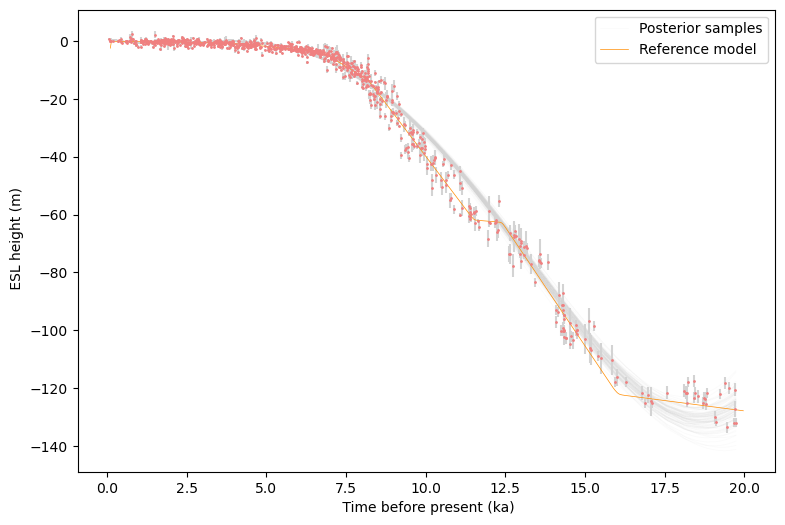

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.7
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
